# 第8讲：不止是cosine！匹配策略决定你召回的质量

> 在前面教程中，我们介绍了如何通过查询重写、各种优化检索策略和召回重排策略来提升检索模块的召回率。其中影响检索召回文档质量的一个关键组件为 similarity，它的作用是用来计算检索的文档和查询 query 之间的相似度。LazyLLM 默认提供的相似度计算函数为 bm25(分为英文和中文) 相似度计算，余弦相似度计算方法。其中 bm25 算法主要针对文本进行计算，而余弦相似度算法主要针对 embedding 进行计算。如果 LazyLLM 提供的默认相似度计算方法不能满足自己的需求，可以自己来设计定义符合自己需求的相似度计算方法。与 Similarity 组件相似，本教程同时介绍 Transform的自定义方法。

本教程主要介绍如何使用自定义 Similarity 组件和 Transform的方法，读完本教程，您将学会 LazyLLM 中自定义 Similarity 和 Transform的方法，并基于 Similarity 和 Transform分别搭建一个简单的RAG应用。

## 为什么要自定义 Similarity

在 RAG服务中，检索模块的效果直接影响生成结果的相关性与准确性。不同应用场景对“相似度”的理解和需求各不相同。例如，在法律或医疗文档中，强调关键词级别的精确匹配；在通用问答场景中，更注重语义层面的理解；而在多模态场景中，则可能涉及文本与图像或结构化数据之间的对齐匹配。为适配多样化需求，LazyLLM 提供了两种通用的相似度计算方法：BM25/BM25\_chinese 和 余弦相似度。尽管这两者在通用场景中具有良好表现，但在某些特定任务中仍存在局限性：


* BM25 无法理解语义近似：它基于词频和词面匹配，无法处理近义词、同义术语或行业特定表述的归一化问题；
* 余弦相似度粒度较粗：在长文本或结构复杂的文档中，局部相关内容容易被整体平均，从而稀释匹配效果。

**我们来看一个示例，关于BM25 无法理解领域语义（近义词、术语归一）的问题。**

**① 示例背景**

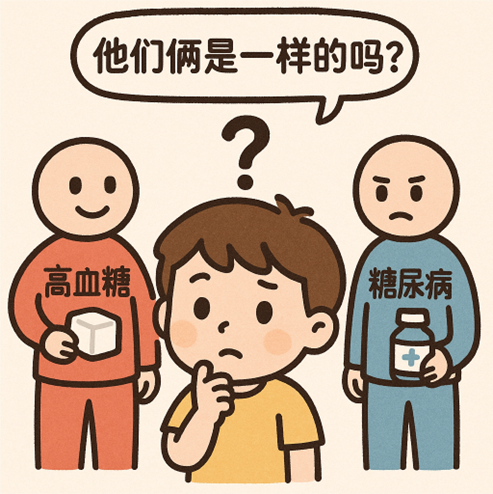

* 用户查询：“高血糖的饮食干预方法”
* 查询说明：用户查询医学相关的资料，使用的是专业术语的同义表达。
* 候选文档：“糖尿病患者应控制碳水化合物摄入，以调节血糖水平。”

**② 理想匹配预期**

“高血糖”是“糖尿病”的核心表现之一。尽管查询和文档表述不同，但在医学语境中高度相关。理想的检索系统应能理解两者间的语义等价关系，从而高质量地命中该文档。

**③ 问题分析**

使用 BM25 或 BM25\_chinese 时，由于它们仅关注词面重合，“高血糖”与“糖尿病”词面不同，因此得分较低，极有可能被错过。这类基于表层匹配的方式在专业领域语义检索中显得力不从心。因此，为提升检索质量，在实际系统中往往需要引入更语义敏感、领域定制化的相似度策略，以适配复杂多变的业务需求。

**接着，看一下另一个示例，关于余弦相似度在长文档中被稀释的问题。**

**① 示例背景**

* 用户查询：“谁具备优秀的项目管理能力”
* 查询说明：用户想找一段描述“张三的项目管理能力”的内容。
* 候选文档（长文档摘要）：“张三毕业于某重点高校，具有多年软件开发经验。他参与多个大型项目的研发与部署，包括某知名 Agent应用开发框架。他的主要职责包括代码实现、团队协作与任务分配。此外，他还在多个关键节点中承担项目负责人的角色，体现出良好的组织能力和推进力。”

**② 理想匹配预期**

用户查询和文档中 “项目负责人”，“组织能力”等 部分高度相关，理想的系统应该能够识别出局部相关性，并提升该文档排名。

**③ 问题分析**

使用基于 TF-IDF 向量化的余弦相似度时，文档的所有词语都被纳入整体向量表示。在这种情况下，像“开发经验”、“代码实现”等内容虽然词频较高，却与查询目标无关，反而稀释了项目管理相关内容的权重，导致整体相似度偏低，文档难以被正确召回或排序靠前。因此，在处理包含多个主题的长文档时，单一的全文向量匹配显得力不从心，更需要引入局部语义感知机制（如片段级匹配、摘要引导、注意力机制等）来增强相关片段的识别与表达。

## 如何自定义 Similarity

### 环境准备

如果您的电脑上安装了Python，请通过下方命令安装lazyllm及必要的依赖包。关于 LazyLLM 的环境更详细的准备可以参考 [第2讲：10分钟上手一个最小可用RAG系统](../chapter2/2.ipynb) 中对应的内容。

In [ ]:
pip install lazyllm

### 实现函数

由于 LazyLLM 只提供了 BM25 和余弦相似度两种相似度计算方式，在实际应用中可能不能满足要求，这就需要自己根据实际需求来定制 similarity。这里我们以 TF-IDF 算法来实现一个 similarity 计算的例子来说明怎么定义及应用。

#### TF-IDF 原理与示例

TF-IDF 全称为 Term Frequency - Inverse Document Frequency，是一种在信息检索和文本挖掘中广泛使用的关键词提取算法。它的核心思想是：一个词如果在一篇文档中频繁出现，但在所有文档中不常见，那么它很可能是这篇文档的重要关键词。

**1. 词频 TF（Term Frequency）**

衡量词语在文档中的重要性：

$$
TF(t, d) = \frac{f(t, d)}{\sum f(w, d)}
$$

其中， f(t,d)  表示词  t 在文档 d  中出现的次数，分母为该文档中所有词的出现次数之和。

**2. 逆文档频率 IDF（Inverse Document Frequency）**

衡量词语在语料库中的稀有程度：

$$
IDF(t) = \log\left(\frac{N}{1 + df(t)}\right) \quad \text{或} \quad IDF(t) = \log\left(\frac{1 + N}{1 + df(t)}\right) + 1
$$

其中， N 为总文档数， df(t) 为包含词  t 的文档数。

**3. 最终计算公式：TF-IDF**

$$
TF\text{-}IDF(t, d) = TF(t, d) \times IDF(t)
$$

**4. 示例分析**

​**文档集**​：

📄 文档1：「大模型 正在 改变 世界」

📄 文档2：「大模型 是 人工 智能 的 关键 技术」

📄 文档3：「我 喜欢 编程」

​**查询**​：「大模型 技术」

🔹 ​**TF（以文档2为例）** ​：共7词

“大模型”出现1次 → TF = 1 / 7 ≈ 0.143

“技术”出现1次 → TF = 1 / 7 ≈ 0.143

🔹 ​**IDF**​（N = 3）

“大模型”：df = 2 → IDF = log(3 / (1+2)) = log(1) = **0**

“技术”：df = 1 → IDF = log(3 / 2) ≈ **0.405**

🔹 **TF-IDF（以文档2为例）**

TF-IDF("大模型") = 0.143 × 0 = **0**

TF-IDF("技术") = 0.143 × 0.405 ≈ **0.058**

> ❗ 注意：为了避免IDF为负值，Sklearn中使用了平滑版，做了一些处理避免了除以 0，也确保了 IDF ≥ 1。

虽然“大模型”是 query 的关键词，但由于它在多个文档中频繁出现，IDF 为 0，无法帮助区分文档。而“技术”这个词仅在文档2中出现，它的 TF-IDF 值高，对区分文档有贡献。

#### 代码示例

[代码GitHub链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter8/rag_tfidf_similarity.py#L1)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.linalg import norm
import sys
import heapq
from typing import List, Tuple
from lazyllm.tools.rag import DocNode

def tfidf_similarity(query: str, nodes: List[DocNode], **kwargs) -> List[Tuple[DocNode, float]]:
    def add_space(s):
        return ' '.join(list(s))
    corpus = [add_space(node.get_text()) for node in nodes]
    query = add_space(query)
    topk = min(len(nodes), kwargs.get("topk", sys.maxsize))
    cv = TfidfVectorizer(tokenizer=lambda s: s.split())
    tfidf_matrix = cv.fit_transform(corpus+[query])
    query_vec = tfidf_matrix[-1]
    doc_vecs = tfidf_matrix[:-1]
    similairyties = cosine_similarity(query_vec, doc_vecs).flatten()

    indexes = heapq.nlargest(topk, range(len(similairyties)), similairyties.__getitem__)
    results = [(nodes[i], similairyties[i]) for i in indexes]
    return results

在上面的代码中，我们首先通过把 query 和 node 中的文本中插入空格，以用于后面的 tokenizer 处理。tfidf算法是调用 sklearn 中的 TfidfVectorizer 来实现的。计算完 query 和 node 的相似度之后，提取 topk 的结果作为输出。现在我们使用下面的例子进行测试。

In [ ]:
query = "今天天气怎么样"

candidates = [
    DocNode(text="今天阳光明媚"),
    DocNode(text="衬衫的价格是100元"),
    DocNode(text="今天天气非常好"),
    DocNode(text="我喜欢吃苹果"),
    DocNode(text="今天天气真糟糕")
]

results = tfidf_similarity(query, candidates)

最后得到如下的输出结果。

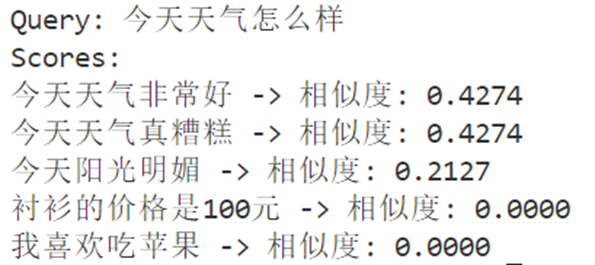

### 注册函数

在上一节中我们定义了一个 tfidf 相似度计算方法，如果想在 LazyLLM 中使用该计算方法，则需要先把该方法注册进 LazyLLM 框架中。对相似度计算方法进行注册是通过装饰器来进行的，即通过 `register_similarity` 装饰器函数进行注册。

> **装饰器**：装饰器（Decorator）是 Python 中的一种高级功能，它允许你在不修改原函数代码的情况下，给函数添加额外的功能（比如日志记录、性能测试、权限验证等）。其本质上是一个 “接受函数作为参数，并返回新函数” 的函数。你可以把它想象成 “函数的包装盒”——把函数放进去，它就会自动获得新能力。实现代码如下。

代码如下:

In [ ]:
import lazyllm

@lazyllm.tools.rag.register_similarity(mode='text', batch=True)
def tfidf_similarity(query: str, nodes: List[DocNode], **kwargs) -> List[Tuple[DocNode, float]]:
    ...

`register_similarity`装饰器函数有四个参数，这里我们详细介绍一下。

* `func`，它是一个可选的调用对象，表示要被装饰的函数，如果没有提供，则会返回一个装饰器函数。
* `mode`，它是可选的字面类型，取值为 "text" 或 "embedding"，表示相似度计算的模式。
  * "text" 表示该相似度计算方法主要是针对文本进行计算的；
  * "embedding" 表示该相似度计算方法主要是针对嵌入向量进行计算的。
* `descend`，它是一个布尔值，指示结果是否按降序排序，默认值为 `True`，需要注意这个参数不是在在计算相似度输出时生效，而是在索引的时候才会生效。
* `batch`，它也是一个布尔值，指示是否支持批量处理，默认值为 `False`。

下面简单展示一下装饰器的三种使用方式：

In [ ]:
# 使用方式1：作为函数使用
func1 = lazyllm.tools.rag.register_similarity(tfidf)

# 使用方式2：作为无参数的装饰器使用
@lazyllm.tools.rag.register_similarity
def tfidf(query: str, nodes: List[DocNode], 
             **kwargs) -> List[Tuple[DocNode, float]]:
    ...

# 使用方式3：作为有参数的装饰器使用
@lazyllm.tools.rag.register_similarity(mode='text')
def tfidf(query: str, nodes: List[DocNode], 
             **kwargs) -> List[Tuple[DocNode, float]]:

### 参数详解

下面我们通过一些小例子来比较每个参数的作用：

#### 1. 参数 `func`

关于 `register_similarity`函数的 `func` 参数，有两种方式使用，一种是正常函数调用的方式传参进去，一种是通过装饰器的方式直接在函数定义时注册。下面为了说明这个参数传进去和没有传进去的区别，我们使用函数调用的方式来演示。

In [ ]:
func1 = lazyllm.tools.rag.register_similarity(tfidf_similarity)
func2 = lazyllm.tools.rag.register_similarity()
print(f"func1: {func1.__name__}, func2: {func2.__name__}")

输出结果为：

```bash
func1: tfidf_similarity, func2: decorator
```

func1 对应的是注册函数传入了相似度计算函数，所以它的返回值是被装饰的相似度计算函数，而 func2 对应的是是没有传入相似度计算函数，所以它的返回值是装饰器函数。

#### 2. 参数 `mode`

Mode，可选的字面类型，取值为 "text" 或 "embedding"，表示相似度计算的模式。

* "text" 表示该相似度计算方法主要是针对文本进行计算的;
* "embedding" 表示该相似度计算方法主要是针对嵌入向量进行计算的;

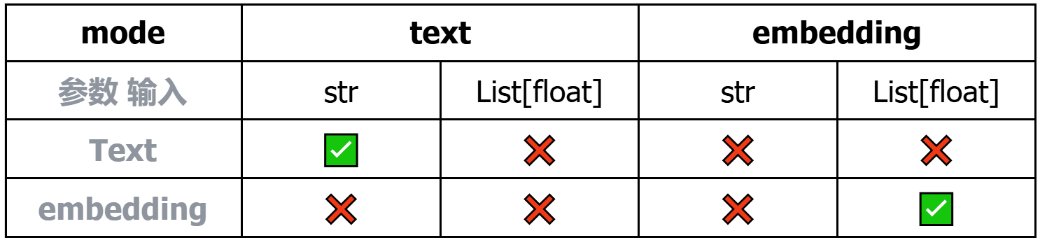

📌 从表中可以看出，我们的输入、mode和参数三者类型必须完全一致才可以使用。但实际使用时，只需要保证函数的node参数类型和注册时候的mode参数一致即可，无需关心query的类型。

这里我们先定义一个欧式距离的计算函数:

In [ ]:
import lazyllm
from typing import List
import numpy as np

def euclidean_distance(query: List[float], node: List[float], **kwargs) -> float:
    point1 = np.array(query)
    point2 = np.array(node)
    return np.linalg.norm(point1 - point2)

然后把这个相似度计算函数注册一下，这里使用不同的mode:

In [ ]:
func1 = lazyllm.tools.rag.register_similarity(euclidean_distance, mode="text")
func2 = lazyllm.tools.rag.register_similarity(euclidean_distance, mode="embedding")

然后我们定义不同的 query 和 node 来用不同模式的相似度计算函数计算相似度，看看效果:

In [ ]:
query_t = "hello world."
node_t = [DocNode(text="hello lazyllm.")]
query_e = {"key": [1.0, 0.4, 2.1]}
node_e = [DocNode(embedding={"key": [4.2, 2.1, 3.9]})]

##### 2.1 用 func1 计算文本的相似度

In [ ]:
ret = func1(query_t, node_t)
print(f"ret: {ret}")

输出结果报错了：

```bash
TypeError: unsupported operand type(s) for -: 'str' and 'DocNode'
```

##### 2.2 用 func1 计算向量相似度

In [ ]:
ret = func1(query_e, node_e)
print(f"ret: {ret}")

输出结果报错了:

```bash
TypeError: unsupported operand type(s) for -: 'dict' and 'DocNode'
```

##### 2.3 用 func2 计算文本的相似度

In [ ]:
ret = func2(query_t, node_t)
print(f"ret: {ret}")

输出结果报错了：

```bash
AssertionError: query must be of dict type, used for similarity calculation.
```

##### 2.4 用 func2 计算向量相似度

In [ ]:
ret_2e = func2(query_e, node_e)
print(f"ret_2e: {ret_2e}")

输出结果为:

```bash
ret: {'key': [(<Node id=2865d5c9-730b-4fda-8077-57b706944ad9>, 4.045985664828782)]}
```

输出结果符合预期，因为 LazyLLM 是支持多 embedding 的，所以前面的 key 表示的是哪类 embedding，然后 tuple 里面的第一项 Node 表示的是哪个节点和 query 进行计算的，第二项表示的是相似度分数。

通过上面四种结果比较，就可以非常清楚 mode 参数的作用了。

#### 3. 参数 descend

descend，布尔值，指示结果是否按降序排序，默认值为 True。需要注意这个参数不是在计算相似度输出时生效，而是在索引的时候才会生效。因为输出时会去重，所以只是返回了topK个node，并不一定以按序排列的。这里我们通过查看 Retriever 检索的结果是否和 query 相似就可以看出该参数的效果了。

我们还是继续使用上面定义的欧氏距离的计算函数，把这个相似度计算函数注册一下，我们先使用 descend 为默认值True的情况:

In [ ]:
import lazyllm
from typing import List
import numpy as np

@lazyllm.tools.rag.register_similarity(mode="embedding")
def euclidean_distance(query: List[float], node: List[float], **kwargs) -> float:
    point1 = np.array(query)
    point2 = np.array(node)
    return np.linalg.norm(point1 - point2)

然后我们使用前面的 [html](https://huggingface.co/datasets/LazyAGI/Html_Knowledge_Base/tree/main) 文档进行测试，我们先定义一个 Retriever 对象：

In [ ]:
import lazyllm
import os
from lazyllm import OnlineEmbeddingModule, SentenceSplitter, Retriever
from lazyllm.tools.rag import Document

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'

documents = Document(dataset_path=os.path.join(os.getcwd(), "rag_data"), embed=OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)
ppl = Retriever(documents, group_name="CoarseChunk", similarity="euclidean_distance", similarity_cut_off=0.003, topk=3)

nodes = ppl("全国住房城乡建设工作会议的主要内容")
for node in nodes:
    print(f"node: {node.text}")

这里我们在定义 Retriever 的时候把前面注册过的 similarity 函数名称传进去即可，然后我们选取 top 3的结果。

输出结果为：

```bash
node: cn/release/blogv2/dist/pc/themesSkin/skin-1024/skin-1024-ecd36efea2.min.css">
    <script src="https://g.csdnimg.cn/lib/jquery/1.12.4/jquery.min.js" type="text/javascript"></script>
    <script src="https://g.csdnimg.cn/lib/jquery-migrate/1.4.1/jquery-migrate.js" type="text/javascript"></script>
    <script type="text/javascript">
        var isCorporate = false;
        var username =  "star_nwe";
        var skinImg = "white";

        var blog_address = "https://blog.csdn.net/star_nwe";
        var currentUserName = "wangjian052163";
        var isOwner = false;
        var loginUrl = "http://passport.csdn.net/account/login?from=https://blog.csdn.net/star_nwe/article/details/141174167";
        var blogUrl = "https://blog.csdn.net/";
        var avatar = "https://profile-avatar.csdnimg.cn/9d615c5dd45743bea262227ce1ce205e_star_nwe.jpg!1";
        var articleTitle = "大模型入门到进阶：什么是 RAG？为什么需要 RAG？RAG 的流程";
        var articleDesc = "文章浏览阅读5k次，点赞22次，收藏25次。学习AI大模型是一个系统的过程，需要从基础开始，逐步深入到更高级的技术。这里给大家精心整理了一份全面的AI大模型学习资源，包括：AI大模型全套学习路线图（从入门到实战）、精品AI大模型学习书籍手册、视频教程、实战学习等录播视频，免费分享！_大模型rag";
        var articleTitles = "大模型入门到进阶：什么是 RAG？为什么需要 RAG？RAG 的流程_大模型rag-CSDN博客";
        var nickName = "AI老猴子";
        var articleDetailUrl = "https://blog.csdn.net/star_nwe/article/details/141174167";
        var vipUrlV = "https://mall.csdn.net/vip?vipSource=learningVip";
        if(window.location.host.split('.').length == 3) {
            blog_address = blogUrl + username;
        }
        var skinStatus = "White";
        var blogStaticHost = "https://csdnimg.cn/release/blogv2/"
          var payColumn = false
    </script>
        <meta name="toolbar" content='{"type":"0","fixModel":"1"}'>
    <script src="https://g.csdnimg.cn/??fixed-sidebar/1.1.7/fixed-sidebar.js" type="text/javascript"></script>
      <script src="https://cdn-static-devbit.csdn.net/ai100/chat/chat-search.js?v=2" type="text/javascript"></script>
    <script src='//g.csdnimg.cn/common/csdn-report/report.js' type='text/javascript'></script>
    <link rel="stylesheet" type="text/css" href="https://csdnimg.cn/public/sandalstrap/1.4/css/sandalstrap.min.css">
    <style>
        .MathJax, .MathJax_Message, .MathJax_Preview{
            display: none
        }
    </style>
    <script src="https://dup.baidustatic.com/js/ds.js"></script>
      <script type="text/javascript">
        (function(c,l,a,r,i,t,y){
            c[a]=c[a]||function(){(c[a].q=c[a].q||[]).push(arguments)};
            t=l.createElement(r);t.async=1;t.src="https://www.clarity.ms/tag/"+i;
            y=l.getElementsByTagName(r)[0];y.parentNode.insertBefore(t,y);
        })(window, document, "clarity", "script", "lgtpix6r85");
      </script>
    <script src="/cdn_cgi_bs_captcha/static/js/waf_captcha_embedded_bs.
node: opener.location.href;
                    }
                } catch (e) {}
            }
            if (referrer) {
                $.post(web_root_url + "/api/waplog", {
                    uuid: $("#uuid").val(),
                    refer: referrer,
                    ua: navigator.userAgent
                }, function(e) {
                    //console.log('waplog:' + e);
                });
            } else {
                //$.post(web_root_url + "/api/waplog", {uuid:'1234567890123', refer:'https://www.baidu.com', ua:'user-agent!'}, function(e){
                //console.log('waplog:' + e);
                //});
            }
            //console.log(navigator.userAgent);



            // 记录分享行为
            var urlSearch = window.location.href.substring(window.location.href.indexOf("?")+1) || "";
            let shareuser = "";
            let shareUrl = ""
            let searchArr = urlSearch.split("&")
            searchArr.forEach((item,index) => {
                let ab = item.split("=");
                if(ab[0] === 'shareuser'){
                    shareuser = ab[1];
                    shareUrl = item;
                }
            })
            // console.log('shareUrl1 ',shareUrl)

            if(shareuser){
                $.ajax({
                    type: 'GET',
                    url: web_root_url + '/japi/pv?article_uuid=' + uuid + '&user_uuid=' + shareuser,
                    dataType: 'JSON',
                    success: function(st) {
                        if (st.suc == 1 && st.info == 'success') {
                        }else{
                        }
                    },
                    error: function() {}
                })
            }
        });
    </script>
    <!-- 与预览页公用 -->
    <script src="https://static.bjnews.com.cn/wap/js/article.js"></script>

    <script src="https://res.wx.qq.com/open/js/jweixin-1.6.0.js"></script>

    <!--分享-->
    <script type="text/javascript">
        $.ajax({
            type: "GET",
            url: "https://m.bjnews.com.cn/api/wxshare?app_id=wxbad48ed25d961bb9",
            // url: "https://m.bjnews.com.cn/api/wxshare?app_id=wxbad48ed25d961bb9",
            dataType: 'json',
            success: function(data) {
                var signpackage = data.signpackage;
                wx.config({
                    // debug: true,
                    appId: "wxbad48ed25d961bb9", // 必填，公众号的唯一标识
                    // appId: "wxbad48ed25d961bb9", // 必填，公众号的唯一标识
                    timestamp: signpackage.timestamp, // 必填，生成签名的时间戳
                    nonceStr: signpackage.nonceStr, // 必填，生成签名的随机串
                    signature: signpackage.signature, // 必填，签名，见附录1
                    jsApiList: [
                        'checkJsApi',
                        'onMenuShareTimeline',
                        'onMenuShareAppMessage'
                    ],
                    openTagList: ['wx-open-launch-app']
                });
            }
        });
        wx.ready(function() {

            var share_uuid = "1735095611129204";
            // 获取url分享后缀
            var wxurlSearch = window.location.href.substring(window.location.href.indexOf("?")+1) || "";
            let wxshareuser = "";//url 分享信息
            if(wxurlSearch){
                let wxsearchArr = wxurlSearch.split("&")
                wxsearchArr.forEach((item,index) => {
                    let ab = item.split("=");
                    if(ab[0] === 'shareuser'){
                        wxshareuser = item;
                    }
                })
            }

            // 处理分享链接
            var shareLinkUrl;
            shareLinkUrl = web_root_url + "/detail/" + share_uuid + ".html";
            if (wxshareuser) {
                shareLinkUrl = shareLinkUrl + "?"
node: </span>llm<span class="token punctuation">.</span>llm <span class="token keyword">import</span> ChatSparkLLM<span class="token punctuation">,</span> ChunkPrintHandler
<span class="token keyword">from</span> sparkai<span class="token punctuation">.</span>core<span class="token punctuation">.</span>messages <span class="token keyword">import</span> ChatMessage
<span class="token keyword">from</span> dotenv <span class="token keyword">import</span> load_dotenv


load_dotenv<span class="token punctuation">(</span><span class="token punctuation">)</span>

<span class="token keyword">if</span> __name__ <span class="token operator">&#61;&#61;</span> <span class="token string">&#39;__main__&#39;</span><span class="token punctuation">:</span>
    spark <span class="token operator">&#61;</span> ChatSparkLLM<span class="token punctuation">(</span>
        spark_api_url<span class="token operator">&#61;</span>os<span class="token punctuation">.</span>environ<span class="token punctuation">[</span><span class="token string">&#34;SPARKAI_URL&#34;</span><span class="token punctuation">]</span><span class="token punctuation">,</span>
        spark_app_id<span class="token operator">&#61;</span>os<span class="token punctuation">.</span>environ<span class="token punctuation">[</span><span class="token string">&#34;SPARKAI_APP_ID&#34;</span><span class="token punctuation">]</span><span class="token punctuation">,</span>
        spark_api_key<span class="token operator">&#61;</span>os<span class="token punctuation">.</span>environ<span class="token punctuation">[</span><span class="token string">&#34;SPARKAI_API_KEY&#34;</span><span class="token punctuation">]</span><span class="token punctuation">,</span>
        spark_api_secret<span class="token operator">&#61;</span>os<span class="token punctuation">.</span>environ<span class="token punctuation">[</span><span class="token string">&#34;SPARKAI_API_SECRET&#34;</span><span class="token punctuation">]</span><span class="token punctuation">,</span>
        spark_llm_domain<span class="token operator">&#61;</span>os<span class="token punctuation">.</span>environ<span class="token punctuation">[</span><span class="token string">&#34;SPARKAI_DOMAIN&#34;</span><span class="token punctuation">]</span><span class="token punctuation">,</span>
        streaming<span class="token operator">&#61;</span><span class="token boolean">False</span><span class="token punctuation">,</span>
    <span class="token punctuation">)</span>

    prompt <span class="token operator">&#61;</span> <span class="token string-interpolation"><span class="token string">f&#34;&#34;&#34;
              你是一个善于回答问题的助手。请使用以下提供的检索内容和自身知识来回答问题。如果你不知道答案&#xff0c;请直接说不知道&#xff0c;不要杜撰答案。请用三句话以内回答&#xff0c;保持简洁。

              问题&#xff1a;</span><span class="token interpolation"><span class="token punctuation">{<!-- --></span>query<span class="token punctuation">}</span></span><span class="token string">

              检索内容&#xff1a;</span><span class="token interpolation"><span class="token punctuation">{<!-- --></span>retrieval_content<span class="token punctuation">}</span></span><span class="token string">
              &#34;&#34;&#34;</span></span>

    messages <span class="token operator">&#61;</span> <span class="token punctuation">[</span>ChatMessage<span class="token punctuation">(</span>
        role <span class="token operator">&#61;</span> <span class="token string">&#34;user&#34;</span><span class="token punctuation">,</span>
        content <span class="token operator">&#61;</span> prompt
    <span class="token punctuation">)</span><span class="token punctuation">]</span>
    handler <span class="token operator">&#61;
```

可以从输出的结果中看到检索出来的文本和请求的query几乎完全没关系，因为我们使用的相似度计算方法是欧氏距离，距离越近说明文本越相似，由于是降序排列，所以 top3 对应的是距离最大的三段文本，那这三段文本和query不相似是符合预期的。

接下来我们在注册相似度计算函数是把 descend 设置为 False:

In [ ]:
import lazyllm
from typing import List
import numpy as np

@lazyllm.tools.rag.register_similarity(mode="embedding", descend=False)
def euclidean_distance(query: List[float], node: List[float], **kwargs) -> float:
    point1 = np.array(query)
    point2 = np.array(node)
    return np.linalg.norm(point1 - point2)

然后我们再运行一次上面的检索代码，发现输出结果为：

```bash
node: <!DOCTYPE html>
    <html data-log-pv='{"mpc":39}'>
    <head>

    <title>全国住房城乡建设工作会议：大力推进商品住房销售制度改革 有力有序推行现房销售_发展</title>
<meta http-equiv="Cache-Control" content="no-transform" />
<meta http-equiv="Cache-Control" content="no-siteapp" />
<meta name="copyright" content="Copyright © 2017 Sohu.com Inc.All Rights Reserved."/>

<meta name="mediaid" content="财联社"/>
<meta property="og:type" content="news"/>
<meta property="og:image" content=""/>
<meta property="og:url" content="www.sohu.com/a/841580226_222256"/>
<meta property="og:release_date" content="2024-12-25 10:27"/>
<meta itemprop="dateUpdate" content="2024-12-25 10:27" />
<meta itemprop="datePublished" content="2024-12-25 10:27" />
<link rel="canonical" href="https://www.sohu.com/a/841580226_222256"/>
<link rel="alternate" media="only screen and(max-width: 640px)" href="m.sohu.com/a/841580226_222256"/>
<meta name="keywords" content="商品,现房,住房,制度,工作,改革,销售,会议,发展,大力,现房,住房,工作会议,房地产,财联社" />
<meta name="description" content="财联社12月25日电，全国住房城乡建设工作会议24日至25日在北京召开。会议指出，2025年，推动构建房地产发展新模式。一是着力优化和完善住房供应体系，加快发展保障性住房，满足城镇住房困难工薪群体刚性住房需求…" />
<meta property="og:description" content="财联社12月25日电，全国住房城乡建设工作会议24日至25日在北京召开。会议指出，2025年，推动构建房地产发展新模式。一是着力优化和完善住房供应体系，加快发展保障性住房，满足城镇住房困难工薪群体刚性住房需求…"/>
<meta property="og:title" content="全国住房城乡建设工作会议：大力推进商品住房销售制度改革 有力有序推行现房销售_发展"/>
        <meta charset="utf-8"/><meta name="data-spm" content="smpc"><meta name="renderer" content="webkit"><meta http-equiv="X-UA-Compatible" content="IE=Edge,chrome=1"/><meta name="viewport" content="width=device-width,initial-scale=1,maximum-scale=1"/><link rel="dns-prefetch" href="//statics.itc.cn"><link rel="dns-prefetch" href="//g1.itc.cn"><link rel="dns-prefetch" href="//js.sohu.com"><link rel="icon" href="//statics.itc.cn/web/static/images/pic/sohu-logo/favicon.ico" type="image/x-icon"/><link rel="shortcut icon" href="//statics.itc.cn/web/static/images/pic/sohu-logo/favicon.ico" type="image/x-icon"/><link rel="apple-touch-icon" sizes="57x57" href="//statics.itc.cn/web/static/images/pic/sohu-logo/logo-57.png"/><link rel="apple-touch-icon" sizes="72x72" href="//statics.itc.cn/web/static/images/pic/sohu-logo/logo-72.png"/><link rel="apple-touch-icon" sizes="114x114" href="//statics.itc.cn/web/static/images/pic/sohu-logo/logo-114.png"/><link rel="apple-touch-icon" sizes="144x144" href="//statics.itc.
node: js"></script>        <script>
try {
        var cfgs = {
        channel_id: "39",
        news_id: "841580226",
        cms_id: "$mpNews.cmsId",
        media_id: "222256",
        passport: "pj6PliNNPJ@virtual-author.com",
        weboUrl: "https://mp.sohu.com/profile?xpt=c29odXptdG5hdnVnMDhAc29odS5jb20=",
        title: "全国住房城乡建设工作会议：大力推进商品住房销售制度改革 有力有序推行现房销售",
        channel_url: "//house.sohu.com",
        integralLevel: "7",
        categoryId: "-1",
        //abData_fd用于abtest
        abData: "",
        // abData_discuss:"4", // 讨论
        abData_discuss: "", // 讨论
        abData_fd: "",
        abData_tw: "",
        originalId: "$mpNews.originalId",
        originalStatus: "10",
        isBaiDuAd: "",
        isPure: "${pure}",
        reprint: false,
        reprintSign: "",
        secureScore: '100',
        sGrade: '0',
        editor: '',
        hideAd: '',
        keywords: "[商品, 现房, 住房, 制度, 工作, 改革, 销售, 会议, 发展, 大力, 现房, 住房, 工作会议, 房地产, 财联社]",
        mpNewsExt: {
            "modelId": ""
        },
        imgsList: [
                                ],
        topNavigation: [
                                     {
                "url": "http://news.sohu.com/",
                "name": "新闻",
            }
                                    , {
                "url": "http://sports.sohu.com/",
                "name": "体育",
            }
                                    , {
                "url": "http://auto.sohu.com/",
                "name": "汽车",
            }
                                    , {
                "url": "http://www.focus.cn/",
                "name": "房产",
            }
                                    , {
                "url": "http://travel.sohu.com/",
                "name": "旅游",
            }
                                    , {
                "url": "http://learning.sohu.com/",
                "name": "教育",
            }
                                    , {
                "url": "http://fashion.sohu.com/",
                "name": "时尚",
            }
                                    , {
                "url": "http://it.sohu.com/",
                "name": "科技",
            }
                                    , {
                "url": "http://business.sohu.com/",
                "name": "财经",
            }
                                    , {
                "url": "http://yule.sohu.com/",
                "name": "娱乐",
            }
                                    , {
                "url": "http://baobao.sohu.com/",
                "name": "母婴",
            }
                                    , {
                "url": "https://healthnews.sohu.com/",
                "name": "健康",
            }
                                    , {
                "url": "http://history.sohu.com/",
                "name": "历史",
            }
                                    , {
                "url": "http://mil.sohu.com/",
                "name": "军事",
            }
                                    , {
                "url": "http://chihe.sohu.com/",
                "name": "美食",
            }
                                    , {
                "url": "http://cul.sohu.com/",
                "name": "文化",
            }
                                    , {
                "url": "http://astro.sohu.com/",
                "name": "星座",
            }
                                    , {
                "url": "https://www.sohu.com/xchannel/TURBd01EQXhPVGt5",
                "name": "专题",
            }
                                    , {
                "url": "http://game.sohu.com/",
                "name": "游戏",
            }
                                    ,
node: 三是大力推进商品住房销售制度改革，有力有序推行现房销售，优化预售<span>资金监管</span>。四是加快建立房屋全生命周期安全管理制度，为房屋安全提供有力保障。五是完善房地产全过程监管，整治房地产市场秩序，切实维护群众合法权益。<a href="//www.sohu.com/?strategyid=00001 " target="_blank" title="点击进入搜狐首页" id="backsohucom" style="white-space: nowrap;"><span class="backword"><i class="backsohu"></i>返回搜狐，查看更多</span></a></p>                <!-- 政务账号添加来源标示处理 -->
        <!-- 政务账号添加来源标示处理 -->
        <p data-role="editor-name">责任编辑：<span></span></p>
    </article>
<div id="articleTransfer"><transfer/></div>
<!-- 评论禁言通知 -->
<div id="bannedNotice"><banned-notice/></div>
<div class="statement">平台声明：该文观点仅代表作者本人，搜狐号系信息发布平台，搜狐仅提供信息存储空间服务。</div><div class="bottom-relate-wrap clear type-3">
            <div id="article-like" data-like-type="type-3">
            <article-like/>
        </div>
        <div class="read-wrap">
        <span class="read-num">阅读 (<em data-role="pv" data-val="$articleStat.pv"></em>)</span>
    </div>
    <div id="articleReport">
        <report/>
    </div>
</div>

                            <div id="sohu-play-content"></div>
                        </div>
                    </div>
                    <div data-spm="middle-banner-ad">
                                            </div>
                                            <div id="articleAllsee" style='height:629px'><all-see-list/></div>
                                        <div class="_0u4o3bh76zbp"></div>
                    <div class="god-article-bottom" id="god_bottom_banner" data-spm="ad-text-bottom" style="display:block">
</div>
<div class="user-god clear" id="user-post" style="display:none">

</div>                    <!-- 评论 -->
                    <div id="meComment" style='min-height: 100px;'>
                        <me-comment/>
                    </div>
                    <div id="commentList">
                        <comment-list></comment-list>
                    </div>
                    <div id="discuss"></div>
                    <!-- 推荐阅读 -->
                                        <div style='min-height:1500px' id="groomRead">
                        <groom-read/>
                    </div>
                                    </div>
                <!-- 右侧边栏 -->
                <div class="sidebar right" id="right-side-bar" data-a="${isBaiDuAd}">
                    <right-side-bar/>
                </div>
             </div>
            <div id="float-btn"> <float-btn/> </div>
            <div class="left-bottom-float-fullScreenSleepContainer" style="display:none;">
    <div class="left-bottom-float-fullScreenSleep" style="display:none;" data-spm="ad-fullScreenSleep">
        <div class="close-tag"></div>
    </div>
</div>
<div class="left-bottom-float" id="left-bottom-god" data-spm="ad-ss">
</div>        </div>
        <script type="text/javascript">
                        window.deployEnv = "prod"
                    </script>
        <script src="//js.sohu.com/pv.js"></script><script src="https://g1.itc.cn/msfe-pcarti-prod/300000000000/assets/js/vendors-d407b7.js"></script><script src="https://g1.itc.cn/msfe-pcarti-prod/300000000000/assets/js/main_article-64e941.js"></script>        <script>
try {
        var cfgs = {
        channel_id: "39",
        news_id: "841580226",
        cms_id: "$mpNews.cmsId",
        media_id: "222256",
        passport: "pj6PliNNPJ@virtual-author.com",
        weboUrl: "https://mp.sohu.
```

这次返回的结果中可以看到都是和请求query相似度很高的文本了，符合预期。

#### 4. 参数 batch

batch，布尔值，指示是否将所有的文档（Node）一次性给到相似度计算公式，默认值为 False。Batch主要是在需要计算均值、方差等统计特征时需要，而不是为了并行计算，LazyLLM 在 similarity 外面已经考虑了并行计算。

##### 4.1 欧式距离计算函数

这里我们先以上面定义的欧式距离计算函数为例，把这个相似度计算函数注册一下，这里使用不同的 batch:

In [ ]:
func1 = lazyllm.tools.rag.register_similarity(euclidean_distance, mode="embedding", batch = True)
func2 = lazyllm.tools.rag.register_similarity(euclidean_distance, mode="embedding")

我们先计算 batch 设置为 True 的相似度计算函数:

In [ ]:
ret = func1(query_e, node_e)
print(f"ret: {ret}")

输出结果报错了：

```bash
TypeError: 'numpy.float64' object is not iterable
```

我们再计算 batch 设为 False 的相似度计算函数:

In [ ]:
ret = func2(query_e, node_e)
print(f"ret: {ret}")

输出结果为:

```bash
ret: {'key': [(<Node id=07cce4d6-6d4f-466b-9895-b0d77f607dbd>, 4.045985664828782)]}
```

因为因为该函数支持非批量计算，所及结果符合预期。

##### 4.2 tfidf 相似度计算函数

接下来我们使用前面自定义的 tfidf\_similarity 来看一下效果，也是先注册一下，这里使用不同的 batch:

In [ ]:
func3 = lazyllm.tools.rag.register_similarity(tfidf_similarity, mode="text", batch=True)
func4 = lazyllm.tools.rag.register_similarity(tfidf_similarity, mode="text")

我们先计算 batch 设置为 True 的相似度计算函数:

In [ ]:
ret = func3(query_t, node_t)
print(f"ret: {ret}")

输出结果为:

```bash
ret: [(<Node id=4a04a93d-28b4-4dbc-83d5-91150f60a648>, 0.7031197927433698)]
```

因为前面定义的 tfidf 相似度计算函数是支持批量计算的，所以结果符合预期。

我们再计算 batch 为 False 的相似度计算函数:

In [ ]:
ret = func4(query_t, node_t)
print(f"ret: {ret}")

输出结果报错了：

```bash
TypeError: 'DocNode' object is not iterable
```

因为该函数不支持非批量计算，所及结果符合预期。

## 使用自定义 Similarity 搭建 RAG 应用

我们先使用 LazyLLM 默认的 similarity 函数搭建一个 RAG 应用。这里我们还是使用前面用过的 html 数据为例进行演示:

In [ ]:
import os
import lazyllm
from lazyllm import pipeline, bind, OnlineEmbeddingModule, SentenceSplitter, Retriever, Reranker
from lazyllm.tools.rag import Document

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'

documents = Document(dataset_path=os.path.join(os.getcwd(), "rag_data"), embed=OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)

with pipeline() as ppl:
    ppl.prl = Retriever(documents, group_name="CoarseChunk", similarity="bm25_chinese", similarity_cut_off=0.003, topk=3)
    ppl.reranker = Reranker("ModuleReranker", model=OnlineEmbeddingModule(type="rerank", source="glm", embed_model_name="rerank"), topk=1, output_format='content', join=True) | bind(query=ppl.input)
    ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | bind(query=ppl.input)
    ppl.llm = lazyllm.OnlineChatModule(source="glm", model="glm-4", stream=False).prompt(lazyllm.ChatPrompter(prompt, extra_keys=["context_str"]))
print(ppl("为什么需要RAG"))

输出结果为:

```bash
需要RAG（检索增强生成）的原因在于大语言模型存在一些固有的局限性。这些局限性主要包括：

1. **时效性**：大语言模型的训练数据集是截至某个时间点的，这意味着之后发生的事件、新发现、新趋势或数据更新都不会包含在模型的知识库中。由于模型的训练需要庞大的计算资源和时间，频繁更新模型以包含最新信息是不现实的。

2. **覆盖性**：尽管大模型的训练数据集非常庞大，但仍可能无法涵盖所有领域的知识或特定领域的深入信息。例如，一些专业的医学、法律或技术问题可能只在特定文献中被详细讨论，而这些文献并未包含在模型的训练数据中。

当大模型面对其训练数据集并未覆盖的问题时，可能会产生不准确或误导性的答案，也就是所谓的“幻觉”。

为了解决这些问题，RAG通过以下流程来增强大语言模型的性能：

- **检索**：根据用户的查询内容，从外部知识库中检索相关信息。
- **增强**：将用户的查询内容和检索到的相关知识整合到一个提示词模板中。
- **生成**：将这个经过增强的提示词输入到大语言模型中，生成更准确、更有针对性的答案。

通过这样的方式，RAG能够弥补大语言模型的不足，减少误导性信息的产生，提高答案的可信度和准确性。
```

接下来我们在这个 RAG 应用中修改为使用前面自定义的 `tfidf_similarity` 方法，因为前面 `tfidf_similarity` 函数已经注册过了，所以这里使用很简单，只需要在 Retriever 初始化的时候指定参数 `similarity` 为我们自定义的相似度计算函数名即可。代码如下:

In [ ]:
import lazyllm
import os
from lazyllm import pipeline, bind, OnlineEmbeddingModule, SentenceSplitter, Retriever, Reranker
from lazyllm.tools.rag import Document

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'

documents = Document(dataset_path=os.path.join(os.getcwd(), "rag_data"), embed=OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)

with pipeline() as ppl:
    ppl.prl = Retriever(documents, group_name="CoarseChunk", similarity="tfidf_similarity", similarity_cut_off=0.003, topk=3)
    ppl.reranker = Reranker("ModuleReranker", model=OnlineEmbeddingModule(type="rerank", source="glm", embed_model_name="rerank"), topk=1, output_format='content', join=True) | bind(query=ppl.input)
    ppl.formatter = (lambda nodes, query: dict(context_str=nodes, query=query)) | bind(query=ppl.input)
    ppl.llm = lazyllm.OnlineChatModule(source="glm", model="glm-4", stream=False).prompt(lazyllm.ChatPrompter(prompt, extra_keys=["context_str"]))
print(ppl("为什么需要RAG"))

输出内容为：

```bash
需要RAG（检索增强生成）的原因在于，大规模语言模型虽然能力强大，但在生成回答或文本时仍存在一些局限性。以下是几个具体的原因：

1. **知识更新限制**：大语言模型的知识是基于训练数据集的，这意味着它的知识是有限的，并且可能不会包含最新的信息。RAG通过检索外部知识库，可以引入最新的信息来增强生成的内容。

2. **上下文敏感性**：在没有额外信息的情况下，大模型可能无法针对特定上下文生成最精确的回答。RAG能够检索与当前上下文相关的信息，使得生成的文本更加准确和贴合。

3. **减少误导性信息**：大模型有时可能会生成不准确或误导性的信息。RAG通过整合检索到的准确信息，有助于减少这种误导性信息的产生。

4. **提升生成质量**：通过结合检索到的外部信息，RAG能够为大模型提供更丰富的上下文，从而优化生成结果，提高文本的质量和相关性。

5. **应对未知或稀疏数据**：对于某些特定领域或稀疏数据集，大模型可能缺乏足够的训练数据来生成高质量的输出。RAG通过检索相关领域的知识，可以帮助模型更好地处理这些情况。

综上所述，RAG旨在利用检索技术来弥补大语言模型的不足，提高生成文本的准确性和相关性，同时降低误导性信息的风险。
```

因为 tfidf 算法不如 BM25 算法的效果好，所以最后输出的结果也不如上面的好，符合预期。

### 查看Similarity分数

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter8/view_similarity_score.py#L1)

这里再补充一点，如何查看检索出来的 node 的 similarity 分数？我们其实可以通过 node 的 similarity\_score 属性即可查看。这里我们还是以 `tfidf_similarity` 为例，代码如下：

In [ ]:
import lazyllm
import os
from lazyllm import OnlineEmbeddingModule, SentenceSplitter, Retriever
from lazyllm.tools.rag import Document

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'

documents = Document(dataset_path=os.path.join(os.getcwd(), "rag_data"), embed=OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)

ppl = Retriever(documents, group_name="CoarseChunk", similarity="tfidf_similarity", similarity_cut_off=0.003, topk=3)

nodes = ppl("全国住房城乡建设工作会议的主要内容")
print(f"nodes: {nodes}")
for node in nodes:
    print(f"node: {node.similarity_score}")

输出结果为：

```bash
nodes: [<Node id=8076e2ef-61c5-46b4-b622-91e9fddf1294>, <Node id=c68319a3-8f34-4cd4-948b-2cb4de22cf0c>, <Node id=7e6c3032-c9b8-4929-bce4-8fbc42417df2>]
node: 0.24727356514169233
node: 0.20530975832300122
node: 0.0970966448783235
```

可以看到检索到的 node 有三个，最高分是0.247，另两个是0.205和0.097。**​注意：Retriever 返回的节点是经过去重的，所以节点的相似度分数不一定是有序的。​**我们怎么能把分数比较低的节点过滤掉呢？这就需要设置 Retriever 中的 `similarity_cut_off` 参数，这个参数的作用就是过滤掉相似度分数低于此阈值的节点。这次我们把 Retriever 中的 `similarity_cut_off` 设为0.21，再看一下效果:

```bash
nodes: [<Node id=f2c8f5eb-4250-4aa1-ba32-81f0fa4c1017>]
node: 0.24727356514169233
```

可以看到这次输出只有一个节点了，说明 `similarity_cut_off` 参数配置生效了。

【补充】在上面 RAG 的代码中，我们可以看见 `Reranker` 实例化时传入了 `output_format` 和 `join` 这两个参数，它们是做什么用的呢？其实它们不光是可以在 `Reranker`里面设置，还可以在 `Retriever`里设置。它们是用来做后处理的。

### Retriever参数详解

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter8/reranker_parameters_explanation.py#L1)

我们先来看 `Retriever` 里面的这两个参数的取值。`output_format` 的有效取值是 `content` 、`dict` 和 `None`，`content` 表示 `Retriever` 检索输出的是 `Node` 的内容，即 `str` 类型。`dict` 表示 `Retriever` 检索输出的是字典类型，即把 `Node` 中的内容转换成字典进行输出。`None` 表示不做任何后处理，直接以 `Node` 类型输出。`join` 的有效取值是布尔值、字符串值。当 `join` 为 `False` 时，只会对 `output_format` 为 `content` 有影响，即不对输出内容进行拼接，是以 `List[str]` 格式进行输出。当 `join` 为 `True` 时，会给 `join` 赋值空字符串。当 `join` 为字符串时同时 `output_format` 为 `content`，则使用 `join` 对 nodes中的文本进行拼接输出，即以 `str` 形式输出。

下面我们用代码演示一下。我们以上面的代码为例进行说明，并使用 LazyLLM 提供的 `bm25_chinese`相似度计算方法，然后使用国学的数据集，[【数据集下载方式】](https://huggingface.co/datasets/LazyAGI/Chinese_Classics_Articles/tree/main)。

In [ ]:
from lazyllm import OnlineEmbeddingModule, SentenceSplitter, Retriever
from lazyllm.tools.rag import Document

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'

documents = Document(dataset_path="rag_master", embed=OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)

ppl = Retriever(documents, group_name="sentences", similarity="cosine", similarity_cut_off=0.003, topk=3)

nodes = ppl("何为天道")
print(f"nodes: {nodes}")

结果输出为：

```bash
nodes: [<Node id=e25dbd6c-fb37-4181-88e5-4dc734afe2bf>, <Node id=3c92362f-f553-4325-9eb9-080d4ceb8757>, <Node id=e863a9b9-9962-4592-9c31-62bbab55052f>]
```

可以看到什么都不设置的话，检索出来的结果是以 Node 形式输出的。

下面我们把 `output_format` 设置为 `dict`:

In [ ]:
ppl = Retriever(documents, group_name="sentences", similarity="cosine", similarity_cut_off=0.003, topk=3, output_format="dict")

运行上面的代码，结果输出为：

```bash
nodes: [{'content': '第一章\n道可道，非常道。\n名可名，非常名。\n无，名天地之始；有，名万物之母。\n故常无，欲以观其妙；常有，欲以观其徼。\n此两者同出而异名，同谓之玄，玄之又玄，众妙之门。\n第二章\n天下皆知美之为美，斯恶已；\n皆知善之为善，斯不善已。\n故有无相生，难易相成，长短相形，高下相盈，音声相和，前后相随，恒也。\n是以圣人处无为之事，行不言之教。\n万物作而弗始，生而不有，为而不恃，功成而弗居。\n夫唯弗居，是以不去。\n第三章\n不尚贤，使民不争。\n不贵难得之货，使民不为盗。\n不见可欲，使民心不乱。\n是以圣人之治：\n虚其心，实其腹；弱其志，强其骨。\n常使民无知、无欲，使夫知者不敢为也。\n为无为，则无不治。\n第四章\n道冲而用之或不盈。\n渊兮似万物之宗，湛兮似若存。\n吾不知谁之子，象帝之先。\n第五章\n天地不仁，以万物为刍狗。\n圣人不仁，以百姓为刍狗。\n天地之间，其犹橐龠乎？\n虚而不屈，动而愈出。\n多言数穷，不如守中。\n第六章\n谷神不死，是谓玄牝。\n玄牝之门，是谓天地根。\n绵绵若存，用之不勤。\n第七章\n天长地久。\n天地所以能长且久者，以其不自生，故能长生。\n是以圣人后其身而身先，外其身而身存。\n非以其无私邪！\n故能成其私。\n第八章\n上善若水。\n水善利万物而不争，\n处众人之所恶，\n故几于道。\n居善地，心善渊，与善仁，言善信，政善治，事善能，动善时。\n夫唯不争，故无尤。\n第九章\n持而盈之，不如其已；揣而锐之，不可长保。\n金玉满堂，莫之能守；富贵而骄，自遗其咎。\n功遂身退，天之道也。\n第十章\n载营魄抱一，能无离乎。\n专气致柔，能如婴儿乎。\n涤除玄览，能无疵乎。\n爱民治国，能无为乎。\n天门开阖，能为雌乎。\n明白四达，能无知乎。\n第十一章\n三十辐共一毂，当其无，有车之用。\n埏埴以为器，当其无，有器之用。\n凿户牖以为室，当其无，有室之用。\n故有之以为利，无之以为用。', 'embedding': {'__default__': [0.02805577, 0.023282783, -0.010409373, 0.053345673, 0.054548774, -0.021444315, -0.03477331, 0.009788121, -0.00026711644, -0.019736782, 0.011505052, -0.0037637316, -0.005963491, 0.041383855, 0.040610127, 0.000985921, -0.0166217, 0.025156088, 0.0017116133, -0.004511433, -0.026657365, 0.027576007, 0.01825779, -0.019136382, 0.011662057, 0.009423636, 0.0024921207, 0.0025204297, 0.0037775566, -0.022618348, 0.0013726661, -0.035238307, -0.013865939, 0.001558638, 0.022386922, 0.008083175, 0.07320647, 0.08896838, -0.0036581368, -0.0025714708, -0.021176474, 0.03489965, -0.040128466, -0.038380902, -0.015130355, -0.013884746, -0.015268907, 0.025365353, -0.03942374, 0.019842712, -0.004921817, 0.037063666, 0.049696382, 0.0022446876, -0.021358738, -0.006035082, -0.03891001, -0.0012354126, -0.004749335, 0.04006749, -0.015485865, 0.01656961, -0.0069618057, 0.02573444, -0.01582435, -0.0034912361, -0.025114788, -0.054328755, 0.0043460196, -0.027710024, 0.032266844, 0.033886887, -0.05694017, 0.024670593, -0.042889997, -0.07643343, -0.027408268, -0.0037645432, 0.049862724, 0.034287237, 0.0019841655, 0.01078216, -0.0059950864, -0.010718801, 0.035949897, 0.043880112, -0.010869555, 0.0025348524, 0.06355861, -0.012848395, 0.022585338, 0.032618817, 0.044830754, 0.022901794, -0.0006210798, 0.023177462, 0.005330909, -0.046414472, -0.0045889826, -0.014616943, -0.033123583, -0.0512881, -0.0020927102, -0.007836456, -0.048342444, -0.0070576523, -0.013562943, 0.02388182, -0.026922677, -0.026092608, 0.012044963, 0.01646408, 0.04047805, 0.06462115, 0.023438517, -0.016478423, 0.02324674, 0.031171313, 0.0362842, 0.018051483, -0.01053648, 0.021465031, 0.023477495, -0.00013451152, -0.011715929, 0.03454124, 0.013441222, -0.046513334, 0.0061332174, -0.0035214778, -0.021454038, 0.05006143, 0.016918018, 0.022030752, 0.007946085, 0.045935158, 0.034973834, 0.00629696, 0.0073370235, 0.025189713, 0.05712071, 0.009955108, 0.050782707, 0.021099582, 0.016486313, -0.050984617, -0.04715113, -0.029727397, 0.04059149, 0.033788107, 0.034945745, 0.05894489, 4.011729e-14, -0.011751112, -0.050978955, 0.05046298, -0.071110204, -0.0019882438, -0.018479101, -0.051272694, -0.010007738, 0.006884054, -0.034583736, 1.1196757e-17, 0.003905397, 0.02047898, 0.035552427, 0.007619795, 0.05529369, -0.020593314, -0.048601326, 0.008128059, 0.0289784, 0.017017765, -0.019920338, -0.028185569, -0.025367916, -0.026009448, -0.027133418, -0.036126122, 0.014420889, -0.0030427186, -0.002751916, -0.022126038, -0.026038717, -0.034733053, -0.0075950925, -0.020967247, -0.020053484, -0.0027370602, -0.037891444, 0.0049866363, -0.04834721, 0.034292456, 0.027533008, 0.018361798, 0.027508227, -0.02045841, -0.017287603, 0.0034947034, -0.043515395, -0.0053127245, -0.043165147, 0.08445005, -0.027922887, -0.016033549, 0.03531948, 0.020594265, 0.03838893, -0.06151098, -0.020862881, -0.0145209795, 2.2020384e-05, -0.0194264, 0.06360542, -0.004401274, 0.017582126, -0.058675535, 0.039020978, 0.05540472, 0.014137382, 0.018975371, -0.027120763, -0.0006975507, -0.0052835485, -0.039460376, 0.0057850983, -0.018254379, 0.056609638, -0.060044613, 0.020291893, 0.006809394, -0.018061927, -0.020031512, -0.022705525, -0.027026203, -0.018345924, 0.016909966, 0.021607758, -0.0012275928, -0.013516523, -0.05039473, -0.051422264, -0.026746254, 0.070365995, -0.0057425452, -0.042636707, 0.04210949, -0.01575858, 0.01585634, -0.014072475, 0.061945125, -0.061828148, -0.09160385, -0.019648878, 0.005205405, 0.04710268, -0.023101546, 0.009841605, 0.046674192, 0.038244978, 0.041187655, 0.06351536, 0.0065300423, -0.018576019, 0.0005083096, 0.0081122685, -0.008605757, -0.0022208246, 0.028158564, 0.02641683, 0.001838783, 0.02509545, 0.0027108253, 0.023963299, -0.041949738, -0.013529197, -0.028406734, 0.012666118, -0.04136234, 0.025941981, 0.029364305, 0.003928735, 0.013956154, -0.029576076, 0.005434449, -0.02822633, 0.033941615, -0.0492418, 0.0077956063, 0.04823387, 0.03536443, 0.0069991727, 0.02820339, 0.016064752, -0.042256713, -0.10030166, 0.008323236, 0.0006843557, 0.022676226, -0.00090373657, 0.0070267376, 0.030184641, -0.01695967, -0.026980516, 0.0632163, -0.010148003, 0.019774279, -0.017960021, 0.026519297, -0.045076273, -0.022787727, -0.009274319, 0.02229007, -0.012502117, 0.030040009, -0.02335761, 0.009685071, 0.05651463, -0.024839891, -0.019800588, 0.03620323, -0.013136933, 0.00065234746, -0.010354659, -0.054040577, 0.0154526085, -0.0008120195, 0.0016255731, 0.027276509, 0.08151536, 0.053237963, 0.040713258, 0.030182822, -0.02873101, -0.063819155, -0.01401389, -0.03257143, -0.0130671365, -0.049955063, -0.020377934, -0.015753347, 0.009992964, 0.013277232, 0.010839926, 0.059939686, 0.028921248, -0.037305593, 0.023923561, -0.01083718, 0.041034095, -0.013648627, 0.039294437, -0.0056047714, 0.03269078, 0.030684272, -0.01967473, 0.029130636, -0.06409252, 0.009602843, 0.013003515, -0.0014473207, -0.00059630856, 0.0007928729, 0.0394453, 0.026099138, 0.0013514259, -0.04909594, 0.009835781, 0.0013566319, 0.042203527, -0.028487109, -0.045480847, -0.028581986, 0.023174047, 0.026821401, 0.08383023, -0.06158942, -0.028400997, -0.007825939, 0.003234013, -0.057725567, 0.0064291023, 0.012853949, 0.020342965, -0.005471113, 0.032541998, -0.0010940416, -0.008109905, 0.01918718, 0.021351868, -0.014318267, -0.012899077, -0.02170698, -0.0069873175, 0.009628323, -0.024537625, -0.015283444, -0.033228494, -0.0014736207, -0.056704417, -0.0048376825, -0.00083587086, -0.013281995, 0.020264463, -0.049195595, -0.024637522, -0.011718843, -0.021825653, 0.004700579, 0.015963696, 0.032105163, 0.0017268145, 0.009395046, 0.03965735, 0.010019313, 0.03593677, 0.0035611999, 0.010699732, 0.052226007, 0.020346584, 0.038028255, -0.0076610018, -0.040621884, 0.011577985, -0.005221753, 0.018597549, 0.031076666, -0.004861098, 0.017033093, 0.039025906, 0.046661437, -0.006155237, -0.012757879, 0.03810979, -0.009047799, -0.030244311, -0.010257482, 0.045990936, 0.02887998, -0.019625623, -0.031448547, -0.01273922, 0.013901697, 0.02527813, -0.03144724, 0.022464182, -0.027144372, -0.02345889, -0.04950639, -0.018502356, 0.017688517, 0.010369425, 0.02123409, -0.028073085, -0.011926072, -0.042963635, -0.058450896, 0.055865563, -0.0059462283, 0.045135874, 0.0077739223, 0.002659368, -0.016431257, -0.02149337, -0.03735157, -0.06444941, -0.0014105599, 0.005779389, 0.078287676, -0.0042932495, -0.021970661, -0.03339254, -0.031541187, 0.016650775, -0.006059932, -0.04497521, 0.02074348, -0.018448783, -0.0050848476, -0.028253563, 0.014440935, 0.0100940475, 0.053356335, -0.083560206, -0.011833814, -0.042367645, 0.036735408, 0.028277006, 0.06732231, 0.014818252, -0.029717922, 0.0019335257, -0.044133835, 0.08157332, -0.037129093, -0.023763556, -0.021009404, 0.024365442, -0.022566712, 0.03615989, 0.019918706, -0.0045654653, -0.0147744175, -0.08768809, -0.027434569, 0.008535524, -0.014643252, 0.04218006, -0.04418376, -0.0063099093, -0.0553463, 0.0038829402, 0.06492348, -0.010223985, -0.02583102, 0.04767369, -0.0031157823, -0.037336517, -0.010527561, 0.012848088, 0.012727778, -0.073188215, 0.019639697, -0.0035746093, 0.011461775, -0.011808149, -0.024037987, -0.01767288, -0.017726846, -0.05001298, -0.015326746, -0.015128984, -0.039607592, -0.041593075, -0.016392805, 0.027638663, -0.007096099, 0.012386369, -0.008532201, 0.021859642, 0.008219009, 0.009499561, -0.013660722, -0.011760268, -0.01918902, 0.030194886, -0.032402657, 0.020689184, 0.038485542, 0.040394958, -0.042311437, -0.005354799, -0.0053760037, 0.013059683, -0.011825115, 0.042120803, 0.010707755, 0.010666628, 0.064930595, 0.022026783, -0.045309015, -0.013215051, -0.0035855586, -0.018754315, -0.04237147, 0.009189613, -0.001861292, 0.01305605, 0.016130973, 0.016797947, 0.04227604, 0.0010169245, 0.00045087113, 0.039859597, 0.010306915, -0.021312863, 0.013667852, 0.0045401216, 0.041180596, -0.0008014906, -0.016648965, -0.047358204, 0.024641568, 0.063572116, -0.05323623, 0.027804086, -0.0231327, -0.00818245, 0.008933412, -0.02742569, -0.024679849, -0.0070232884, 0.07939336, 0.011911154, 0.038045548, 0.01569419, 0.0052608084, 0.01345627, -0.032691434, -0.006347253, 0.04491138, 0.012246293, -0.014546515, 0.0090763355, 0.022790618, -0.036779568, 0.04574143, -0.023112146, 0.039602417, 0.024539718, 0.029363053, -0.057744678, -0.00423374, 0.041941483, -0.018338485, -0.006981724, 0.036857042, -0.0051898616, -0.02998108, -0.025315555, 0.011249301, 0.013763156, -0.0014266107, -0.003557593, 0.029689435, -0.008416172, 0.0055658235, 0.041912172, -0.0066596386, 0.014426449, 0.027964776, 0.041610844, 0.030743865, -0.019479757, -0.015880436, 0.013414679, 0.033685517, 0.025084984, 0.0119731445, -0.032747474, -0.016790409, -0.010821385, 0.020628633, -0.019503403, -0.00031055597, -0.038631473, -0.005416922, -0.044260085, 0.009548929, -0.054613594, -0.027896475, -0.028240051, 0.013305551, 0.0026884757, 0.0029414417, -0.04595156, -0.06401382, -0.0026240156, 0.018469386, -0.022476513, 0.011497057, 0.087008506, 0.026063265, -0.069855325, -0.00500086, -0.01826556, -0.011640849, 0.015342398, -0.032531984, 0.033423632, 0.037746735, -0.063191675, 0.009925365, 0.032167457, 0.011919864, -0.024339493, 0.03451287, 0.0016408766, -0.027204601, 0.022536965, -0.0034854359, -0.05221978, -0.002954332, 0.00039458516, -0.037060868, 0.04824446, -0.038343217, -0.008858709, -0.020064302, -0.034424454, -0.0008146635, -0.03229093, 0.020989783, 0.038041, 0.04462357, 0.022627661, 0.021487724, 0.016195275, 0.058926657, 0.0016035914, -0.0781729, -0.01440017, -0.065230064, -0.04473913, -0.05347233, 0.0056564305, 0.026773501, 0.0093747275, -0.0023014166, 0.034559432, -0.014295065, 0.059227344, 0.016397202, -0.010564607, -0.016085293, 0.027223522, -0.039766714, -0.013913507, -0.021724187, 0.019855114, 0.046961125, -0.050933924, 0.028491676, -0.025045706, -0.05075212, 0.034840867, 0.030845476, 0.037544426, -0.04044042, 0.06494801, 0.02402745, 0.027269753, -0.02984972, 0.032292705, -0.0031673112, -0.013952973, -0.024952147, -0.0055473237, 0.020091854, -0.0025514988, -0.030173488, -0.017058272, -0.027787264, 0.025821265, 0.035203192, -0.004649104, -0.0053550736, 0.00918115, -0.033489943, 0.025983026, 0.037477348, -0.01963841, 0.03444502, 0.03194153, -0.06143998, 0.045849923, -0.034311283, 0.042799775, 0.023144597, -0.01235297, -0.0723703, -0.017136108, 0.007224321, -0.0083739795, -0.01820453, -0.011421597, 0.008455473, -0.016129691, 0.014105691, -0.004665744, -0.010970606, 0.032578386, -0.02076877, 0.0136699425, -0.0101013975, -0.032376077, 0.07448448, -0.03354995, 0.035129014, -0.0034162682, -0.019508207, 0.009046866, 0.0062084193, -0.11542149, 0.0007030675, 0.015893739, 0.009404671, 0.003927252, 0.02014505, 0.009974044, -0.028185304, -0.0127715375, 0.04931239, 0.03772544, 0.027806891, 0.030862588, -0.0037065197, -0.04931788, -0.007824991, 3.4293641e-09, -0.0051761563, 0.025381971, -0.008663922, 0.015905118, -0.04079911, -0.019575298, 0.06621208, -0.0035683208, 0.00025738007, 0.04481607, 0.054077428, -0.0072247866, 0.009435948, -0.023140049, -0.05412917, 0.008451867, -0.010966122, -0.034531895, 0.004752035, -0.04602555, -0.0023236184, 0.009561207, -0.023378637, 0.02203002, 0.017096436, 0.03657697, -0.00084620155, 0.004841395, 0.05531498, 0.016193043, 0.012097276, 0.053189192, 0.025982248, -0.03255773, 0.009982884, -0.036482878, -0.0074970718, 0.091324344, 0.0009932049, -0.006143996, 0.0119158905, -0.03613227, 0.047933377, -0.008942387, -0.026436765, 0.0150227435, 0.020003684, 0.07058418, 0.066080704, 0.028907618, -0.044925384, 0.01017655, -0.02693322, -0.03381552, 0.003237652, 0.012430394, -0.014999726, 0.026932973, -0.03142256, -0.023699204, -0.019175638, 0.034598034, 0.0006931077, -0.014283599, -0.008699737, 0.06428559, -0.011042515, 0.038128216, 0.022812221, -0.02596328, 0.0021123243, -0.026327409, -0.0008933892, -0.025974091, 0.03291074, -0.0022326256, 0.008192097, 0.013533811, -0.02715469, 0.0126990145, 0.024964565, 0.05334236, -0.023978073, 0.018099934, -0.01582323, -0.06513108, 0.009603815, -0.042491097, -0.0066699567, -0.007812225, -0.009894219, 0.00089794875, -0.0269737, 0.079909176, -0.043051008, -0.040161613, -0.012302384, -0.009370962, 0.00968951, -0.003516922, 0.02560884, -0.0031629042, -1.8169522e-27, 0.019083612, 0.05595246, 0.08110245, 0.009914496, 0.045291685, 0.077853344, -0.05095552, -0.023066273, -0.013523827, -0.030841304, -0.045739565, 0.03553436, -0.00127252, 0.011472, -0.0025980568, 0.03063463, 0.0018815541, 0.036709815, 0.0418239, 0.0048987665, 0.051705733, 0.027615868, 0.024299819, 0.0338089, -0.034141615, 0.0012112331, 0.045954734, -0.050197713, 0.0018632635, 0.038185284, 0.043542426, 0.003177657, 0.02623213, 0.047126044, 0.032685865, 0.018318154, 0.0059990953, 0.014030563, 0.06493271, 0.06270943, -0.034145653, -0.024160989, 0.01995237, -0.082519315, -0.026380774, -0.0008480955, 0.006037592, -0.027352571, 0.00014761026, -0.02092509, 0.024393355, 0.010887946, 0.014051744, -0.050117142, -0.026565975, 0.02288321, 0.0013072105, -0.051732846, 0.029837305, 0.008642002, 0.0039808676, 0.03630373, -0.0036453824, 0.04533731, 0.04966945, 0.010970786, 0.010568572, -0.009174333, -0.030876184, 0.02845327, 0.0035904122, -0.004267927, 0.020078829, -0.052125897, -0.047840167, 0.044615194, -0.012507692, -0.03702641, 0.020036895, 0.0070881178, -0.017886484, 0.023605479, -0.01983722, -0.016965086, -0.016553123, 0.057427112, 0.02306789, -0.028244715, -0.00089197716, 0.0067641498, -0.01275369, -0.0065226373, -0.009160864, -0.0067051817, 0.021619145, -0.034704223, -0.007742388, -0.019153567, -0.0031101278, 0.023993352, -6.7284605e-24, 0.019229813, 0.036678217, 0.026083732, 0.007746939, 0.005390164, -0.02422693, 0.013378925, 0.0064707967, 0.022271916, 0.0047905026, 0.027713606, -0.059018284, 0.06695722, 0.0046320846, 0.020561788, -0.054861706, -0.013244152, 0.024165925, 0.016604742]}, 'metadata': {}}, {'content': '观天之道，执天之行，尽矣。\n故天有五贼，见之者昌。\n五贼在心，施行于天。\n宇宙在乎手，万化生乎身。\n天性人也，人心机也。立天之道，以定人也。\n天发杀机，移星易宿；地发杀机，龙蛇起陆；人发杀机，天地反覆；天人合发，万化定基。\n性有巧拙，可以伏藏。九窍之邪，在乎三要，可以动静。\n火生于木，祸发必克；奸生于国，时动必溃。知之修炼，谓之圣人。\n天生天杀，道之理也。天地万物之盗，万物人之盗，人万物之盗。三盗既宜，三才既安。\n故曰食其时，百骸理；动其机，万化安。人知其神之神，不知不神之所以神也。\n日月有数，大小有定，圣功生焉，神明出焉。\n其盗机也，天下莫能见，莫能知。君子得之固躬，小人得之轻命。\n瞽者善听，聋者善视。绝利一源，用师十倍。三返昼夜，用师万倍。\n心生于物，死于物，机在目。\n天之无恩而大恩生。迅雷烈风莫不蠢然。\n至乐性余，至静性廉。天之至私，用之至公。\n禽之制在气。生者死之根，死者生之根。恩生于害，害生于恩。\n愚人以天地文理圣，我以时物文理哲。', 'embedding': {'__default__': [0.0041554114, 0.0075854566, -0.007057654, 0.045291275, 0.04896368, 0.028331915, -0.05941855, 0.023905145, 0.041470468, -0.048525453, 0.041954085, -0.009402919, -0.026280737, -0.0059798467, 0.03535848, -0.01118226, -0.034457922, 0.05115644, -0.0008446922, -0.026550785, -0.007863325, 0.027618073, -0.011360486, -0.039742425, -0.004911823, -0.04183471, -0.005898696, 0.044848423, -0.030583072, -0.01361686, 0.038467087, -0.04660302, -0.02357292, 0.04048558, 0.03306541, -0.027309675, 0.048068833, 0.088752195, -0.009470059, 0.014505637, 0.0019608818, 0.024321485, -0.0624449, -0.050921675, -0.009048667, -0.014897456, -0.02090078, 0.0161172, -0.031017896, -0.006250185, 0.0034054928, 0.017325701, 0.05056032, 0.007071267, -0.008573053, 0.0057591763, -0.032224294, 0.015077854, -0.021500586, 0.050998785, -0.012885331, -0.0015166812, 0.016822474, 0.010382974, -0.01868565, -0.029895348, -0.035598777, -0.017912406, 0.003902434, -0.019268971, 0.025545066, -0.0016119897, -0.07398274, -0.0090994835, -0.015249873, -0.05385994, 0.041456234, 0.025098544, 0.011212095, 0.023621807, 0.02871689, 0.0155634, -0.017000291, -0.0057249004, 0.041292667, 0.014244264, -0.020487353, 0.009796285, 0.0017768699, 0.0029904752, -0.021676986, 0.050575286, 0.05815488, 0.041090943, 0.03852607, 0.0007469177, 0.0146834655, -0.019205064, -0.02501764, -0.014589938, -0.025496105, 0.0029830346, 0.009922189, -0.014940715, -0.05994815, 0.018909076, -0.0024642693, 0.04501117, -0.047053687, -0.014784821, -0.0020920835, 0.035193928, 0.042950764, 0.048697557, -0.015930817, -0.018142601, -0.021126166, 0.0013488104, 0.02504943, -0.007454921, -0.026205262, 0.03224436, 0.06320423, 0.0017354549, -0.013907578, 0.053008184, 0.013806328, -0.040066086, -0.011262496, -0.00783606, -0.032809734, 0.042265926, 0.003031213, -0.011611754, 0.0038381496, 0.026966704, 0.042800177, 0.032915533, 0.016108219, 0.019568527, 0.06046945, -0.010420891, 0.03388435, -0.0009712575, 0.032708555, -0.039891865, -0.029775867, -0.014499864, 0.022318674, 0.029443137, 0.010519894, 0.057602942, -2.1037191e-13, -0.040184353, -0.023729598, 0.059133578, -0.060146023, -0.009997531, 0.0071468763, 0.02307546, -0.008445198, 0.025550805, -0.062879466, 1.1355897e-17, 0.005254596, 0.039959684, 0.008519935, 0.028987143, 0.069844805, -0.014054391, -0.035702214, 0.03448102, 0.035850395, -0.026240302, -0.060955, -0.015616291, 0.005105854, -0.03699429, 0.013898516, -0.011044874, -0.008250217, 0.017763525, 0.014568678, 0.011624834, -0.016273065, -0.016237382, -0.030793475, -0.014173828, -0.004470327, -0.00031035003, -0.047902904, -0.033007123, -0.037031222, 0.0365982, 0.030188967, 0.030725434, 0.023961129, -0.02410339, -0.029226728, 0.03464168, -0.024372779, -0.021495208, -0.057038497, 0.073897764, -0.0141333, 0.019894436, 0.05053698, -0.012459984, 0.030188244, -0.0424957, -0.009643966, -0.001958911, 0.020065648, 0.014195304, 0.0558965, 0.01836145, -0.031815484, -0.03150872, 0.0695297, 0.031345744, 0.008421123, 0.0014973548, -0.033643615, -0.014629425, 0.022442328, -0.028167598, 0.015380408, -0.014378052, 0.012282112, -0.053193033, 0.019917091, 0.019215647, -0.033822346, 0.0027193974, -0.014981052, 0.00055290776, -0.004483305, -0.006755365, 0.028678952, 0.023475507, 0.020434262, -0.03490839, -0.027436005, 0.010972408, 0.07965436, 0.0011874165, -0.045413267, 0.028245784, -0.0063281492, 0.009295957, -0.03730253, 0.06491051, -0.045857605, -0.06690101, -0.0045730066, -0.024991188, 0.034862872, -0.015739491, 0.0529046, 0.03173905, 0.0703093, -0.0026089184, 0.054319624, 0.007398687, -5.9605067e-05, 0.017072119, -0.008852119, 0.0026614992, 0.038429067, 0.016159521, 0.026893796, -0.035562247, 0.038095932, 0.0065683676, 0.03324841, 0.016334219, -0.023613118, -0.040397674, -0.009194677, -0.008144042, -0.016446576, -0.01151405, -0.010928354, 0.038340032, -0.027145639, -0.046593655, 0.015169281, 0.050768223, -0.03294848, 0.01951992, 0.013797078, 0.035349254, 0.008481241, 0.031466227, -0.003075734, -0.029220875, -0.07521815, -0.0043719853, 0.048672307, 0.0058878683, -0.019860264, -0.03880463, 0.016394598, -0.0122021, -1.4963505e-05, 0.044320922, 0.007890018, 0.0054832306, -0.0123292245, 0.03318079, -0.015232731, -0.013402485, -0.02389836, 0.0055185272, -0.028106516, 0.022771437, -0.030289527, 0.02677829, 0.083992176, -0.012977583, -0.020257147, 0.07025292, -0.0054380586, 0.00113687, -0.003930704, -0.059119448, 0.0005393099, 0.006615847, -0.008725304, -0.011702107, 0.07533191, 0.028773967, 0.029288677, 0.048617944, -0.012453482, -0.02434141, -0.026455658, -0.038755085, 0.010074069, -0.043186586, -0.008087229, -0.030695459, 0.0028579491, 0.010711575, -0.027886447, 0.024541127, 0.011004065, -0.06523756, 0.043040413, 0.025965191, 0.013071675, 0.023030335, 0.029349305, 0.021783385, 0.018128468, 0.006819187, 0.006515866, 0.029666856, -0.06356491, 0.039198253, -0.011071719, 0.023561964, -0.03198062, 0.023516942, 0.059817895, 0.004185616, -0.008066767, -0.009041066, 0.015803682, 0.0067058923, 0.041337356, 0.0052649537, -0.027125185, -0.038213175, 0.014553458, 0.04226332, 0.070982724, -0.11455366, -0.032585356, 0.0102267265, 0.011878967, -0.033385586, 0.0010560753, -0.015395409, -0.00441643, -0.01337264, -0.011390325, 0.03452036, -0.0043478706, 0.021369405, 0.022401562, -0.022205178, 0.01836901, -0.040310632, -0.014155401, 0.022052731, -0.033351872, 0.023539973, 0.0066144154, -0.02636437, -0.049085867, 0.021261329, 0.025078895, -0.03848087, 0.031188102, -0.048261605, 0.019504659, -0.005102396, -0.01836231, 0.02110646, 0.025233712, 0.031062676, 0.0010754078, -0.017802356, -0.013914974, 0.014522387, 0.056926217, 0.0053230077, 0.028501919, 0.048797324, 0.023192475, 0.027942462, 0.0073998393, -0.03499081, 0.022158591, -0.019583017, 0.005857129, 0.046547387, -0.038932085, 0.040460087, 0.042364065, 0.0429083, 0.009138595, -0.012183861, 0.058576614, -0.030963775, -0.034653503, -0.025639888, -0.011284233, 0.047425315, -0.029514484, -0.036847457, -0.019771382, 0.008259031, 0.022998115, -0.017095372, 0.0066413945, -0.05487991, 0.002815856, -0.033681728, -0.014198309, 0.026634654, -0.00822199, -0.00530929, -0.011223847, -0.011880681, -0.034348324, -0.04212451, 0.067977875, -0.034103774, 0.05572993, -0.0062887007, 0.010488381, -0.020459691, 0.012848595, -0.025240324, -0.06849307, 0.025805129, -0.011156502, 0.05313631, -0.024320655, -0.028916016, 0.010576907, -0.0015999046, 0.024717461, -0.0144396275, -0.055715647, 0.030035136, 0.05483442, 0.010892865, -0.0075423573, 0.03750252, -0.005360984, 0.061075144, -0.05138248, -0.018550297, -0.06849128, 0.03832335, 0.051121823, 0.07625229, -0.02237382, -0.02532701, 0.005352677, -0.008111206, 0.073260285, -0.050452314, -0.03776045, -0.049333394, 0.044611394, -0.026005713, 0.039077275, 0.0220915, -0.029445095, -0.0064717205, -0.027871978, -0.035875883, 0.0024223006, 0.018516455, 0.05704868, -0.03898351, 0.006290837, -0.06967245, -0.021957148, 0.030887723, 0.019454552, -0.016694501, 0.013290308, -0.0031141401, -0.013080929, -0.016133493, -0.014472164, -0.01712892, -0.037303273, 0.027202567, -0.020992804, 0.042868, 0.013083941, -0.0220378, 0.004116772, -0.014082884, -0.03672434, -0.025468608, -0.004967429, -0.043549094, -0.059921604, -0.0267599, 0.020867042, -0.024328588, -0.009694849, -0.008663098, 0.029830154, 0.015654892, -0.01019365, -0.005135016, -0.005788498, 0.005652381, 0.018197127, -0.048258357, 0.018697621, 0.009251598, 0.013933649, -0.05764918, 0.017524255, -0.055997822, 0.00016845911, -0.02751447, 0.032793835, 0.0019559327, -0.0075224875, -0.01907267, -0.008904949, -0.030548248, 0.013870509, 0.0069685555, -0.028905436, -0.02268364, -0.020575576, -0.0030170542, 0.015130529, -0.00084239285, -0.029587327, 0.037500374, -0.027868606, -0.006660683, 0.031205097, 0.012189993, -0.000101473976, 0.012176301, -0.012304269, 0.016419522, -0.031622086, -0.031915437, -0.07447143, 0.044259857, 0.034456633, -0.030144012, 0.006155522, -0.047044933, -0.053129446, -0.003883295, -0.02238673, -0.036794078, 0.018963076, 0.038487703, 0.043547265, 0.020530019, 0.013525153, 0.03025931, -0.012935889, 0.0006987865, 0.001170972, 0.049213756, -0.021247994, -0.010136263, -0.008933942, 0.040884793, -0.014472714, 0.04323616, -0.024579003, 0.044722065, -0.00044178023, 0.022410542, -0.043617256, 0.022241985, 0.04859234, -0.034833476, 0.013860875, 0.023002412, 0.00644085, -0.01903299, -0.030982777, -0.02251995, 0.025486361, 0.013646234, -0.025401177, 0.028737532, -0.0021397755, 0.005839515, 0.031907808, -0.017933525, 0.0054767667, 0.011915933, 0.04648308, -0.0016207868, -0.02563286, -0.044512413, 0.03895756, 0.026000049, 0.028605616, 0.0051885676, 0.0020558056, 0.0013344906, 0.018722871, 0.01694392, -0.048954893, -0.0022045183, -0.04172797, -0.021244593, 0.013639434, 0.0023175476, -0.057096064, -0.017740823, -0.041350298, -0.0043968866, -0.03799386, -0.0042910026, -0.09530829, -0.038248345, -0.030624647, -0.0110857375, -0.010244377, 0.046464287, 0.11650956, 0.015119723, -0.069281384, 0.01305812, 0.012854464, -0.0055132634, 0.018360458, -0.0165773, -0.0032716265, 0.031324998, -0.047736414, 0.014519401, 0.048135165, -0.035682708, -0.0365996, 0.03389063, -0.0043802285, -0.01877874, 0.04836236, 0.020456195, -0.056787007, 0.010132782, 0.0004068694, -0.047474485, 0.03445135, -0.02724392, -0.03328944, -0.0029203526, -0.026272407, -0.00029890105, 0.013430369, 0.013834825, 0.060670216, 0.012882629, 0.06432347, 0.015768427, -0.010093849, 0.024928765, 0.012602784, -0.064383924, -0.0050611207, -0.044316787, -0.041941397, -0.04322314, 0.006486478, 0.0071116807, -0.012460606, -0.0074164756, 0.029274957, -0.024530469, 0.018598046, 0.03159384, -0.001951544, 0.00523427, 0.010126147, -0.017179206, -0.018108787, -0.007169589, 0.009502527, 0.008932048, -0.069397494, 0.044141974, -0.005750729, -0.045750074, 0.023508383, 0.03368248, 0.027255893, -0.015447886, 0.056365486, 0.008277988, 0.008696923, -0.059466016, -0.0071224286, 0.020547476, 0.028926386, -0.031088999, 0.0034343835, -0.009711087, 0.0011468836, -0.013077483, -0.025331382, -0.016229326, 0.02545839, 0.011994319, 0.008591205, -0.0015080342, 0.02231805, -0.04337707, 0.040335864, 0.026538009, -0.0062174527, 0.050592676, 0.029670224, -0.013418461, 0.0727519, -0.037769295, 0.04368287, 0.03542585, -0.020641856, -0.05900921, -0.027732523, 0.0072757383, -0.019184208, -0.013169488, 0.022744527, -0.010796951, 0.013560294, -0.035595182, 0.023965288, 0.010551866, 0.024181299, -0.03136934, -0.044932388, -0.020812577, -0.054782774, 0.04152298, -0.011101999, 0.024159305, 0.019186165, -0.062283333, 0.042109832, -0.0031904012, -0.056608956, 0.030812602, 0.020276703, 0.03021552, -0.039611798, 0.03263928, -0.008093682, -0.029934445, -0.003328774, 0.04017525, 0.05742037, 0.065777995, 0.011823178, -0.022649916, -0.030095868, -0.029602733, 3.6471364e-09, 0.019888746, 0.042886823, -0.013049726, 0.037731685, -0.036016267, -0.046768334, 0.060499705, 0.00012572506, 0.016042653, 0.024610577, 0.033402827, 0.004141988, -0.0006018001, -0.055084515, -0.039775707, 0.008617055, -0.01653752, -0.013155907, 0.016346993, -0.023589248, 0.024627982, -0.012017998, -0.053784538, 0.037820525, 0.03518804, 0.046451963, 0.016566351, 0.019617809, 0.03032722, 0.051768657, 0.003973617, 0.011890001, 0.030245746, -0.009497901, -0.001179198, -0.026856216, 0.015133692, 0.04234234, 0.007812807, -0.02503269, 0.017157003, -0.061224688, 0.04974642, 0.033100616, -0.0151869515, 0.024570305, 0.018643305, 0.06040034, 0.038901594, 0.04535261, -0.04548045, 0.0020181928, -0.034227967, -0.0013509532, -0.030452356, -0.018487962, -0.023855759, 0.05625316, -0.00090770074, -0.00640004, -0.014777776, 0.027941104, 0.016304482, -0.038740773, 0.011337658, 0.07173977, -0.03550307, 0.023911772, -0.0016779553, -0.033899304, -0.022336006, -0.015419301, 0.001863339, 0.0008760349, 0.009762301, -0.028453615, -0.011362094, 0.04275605, -0.043521807, 0.029829519, -0.02416117, 0.0335993, -0.006421268, 0.04060249, -0.032474253, -0.07600941, 0.004471598, -0.04126713, -0.02453735, 0.011764305, 0.015372352, 0.0028955622, -0.0291478, 0.05877516, -0.009823992, -0.054267995, 0.0067844344, 0.03217804, -0.011592191, -0.00035714993, 0.028778687, 0.0087011475, -1.7158678e-27, 0.0017932786, 0.03569676, 0.054138917, -0.008628211, 0.043432187, 0.023903232, -0.0067582014, -0.03050816, -0.028248005, -0.02057966, -0.057666212, 0.031576764, -0.0151130445, -0.027907273, 0.019604214, 0.019528171, -0.030740337, 0.013142259, 0.04407093, -0.0029533103, 0.0063910317, 0.017176246, 0.032132074, 0.022815445, -0.050552312, -0.020800956, 0.018182818, -0.037349436, 0.014202859, -0.00087027677, 0.058879256, 0.0056527536, -0.005539146, 0.032238558, 0.022045877, 0.03943093, 0.0077616903, 0.02564012, 0.06469182, 0.020434259, -0.028960383, -0.01953917, 0.016642196, -0.04865382, -0.009785435, 0.00070976716, 0.005543073, -0.00053107564, 0.019826816, -0.046817478, 0.02328427, 0.0038257786, 0.041383106, -0.049317617, -0.012191691, 0.040143386, -0.020945452, -0.015941637, 0.014165448, -0.014123277, 0.0048813364, 0.009677354, -0.001581121, 0.03251474, 0.042997185, -0.015337093, -0.021302974, -0.03482498, -0.02814613, 0.014423916, 0.030641912, -0.0033474728, 0.019615268, -0.046341933, -0.007550764, 0.014528103, -0.024804426, -0.04388465, -0.00038302864, 0.018112512, 0.016945953, 0.022862429, -0.06407195, 0.02999205, -0.029377965, 0.038923685, -0.003280456, -0.0140948305, -0.016372854, -0.0024543288, -0.019321902, 0.029282054, -0.0075866296, -0.018350568, 0.014755779, -0.050756894, -0.038549382, -0.026098477, 0.0016459071, 0.023259882, -6.1448135e-24, -0.022952693, 0.022025546, 0.014744688, 0.009926959, 0.044778008, 0.018253125, 0.04506746, -0.019753184, 0.046412323, 0.00015234029, 0.060078166, -0.060511682, 0.055275027, 0.02107507, 0.0074826907, -0.026740791, -0.012698739, 0.017056648, 0.050418142]}, 'metadata': {}}, {'content': '天命之谓性，率性之谓道，修道之谓教。\n道也者，不可须臾（yú）离也；可离，非道也。是故君子戒慎乎其所不睹，恐惧乎其所不闻。莫见（xian）乎隐，莫显乎微，故君子慎其独也。\n喜怒哀乐之未发，谓之中；发而皆中节，谓之和。中也者，天下之大本也；和也者，天下之达道也。致中和，天地位焉，万物育焉。\n\n仲尼曰：“君子中庸，小人反中庸。君子之中庸也，君子而时中；小人之反中庸也，小人而无忌惮也。”\n\n子曰：“中庸其至矣乎！民鲜能久矣！”\n\n子曰：“道之不行也，我知之矣：知者过之，愚者不及也。道之不明也，我知之矣：贤者过之，不肖者不及也。人莫不饮食也，鲜能知味也。”', 'embedding': {'__default__': [0.025426213, 0.034025285, -0.031320818, 0.016555943, 0.06301127, 0.0053874906, -0.03851282, 0.05617112, -0.026647208, -0.04409193, 0.07942905, -0.016034704, 0.0020301498, 0.009465688, 0.022152705, -0.02026594, -0.05420044, 0.048457634, 0.029878676, -0.023549352, 0.016439304, 0.034842428, 0.020412622, -0.0025755076, 0.0027205113, -0.022589676, 0.020291883, 0.03922448, 0.009154288, -0.007037486, 0.018945666, -0.038242333, -0.0059177317, 0.035270065, 0.023194453, -0.024663404, 0.045518205, 0.078890085, -0.0049626785, -0.0013358546, -0.020847179, 0.008833306, -0.057070132, -0.046780605, 0.0070816474, 0.009134139, -0.019501934, -0.034442246, -0.03516072, 0.006713291, -0.006998874, 0.032105204, 0.052466325, 0.02138813, -0.009691537, -0.009268791, -0.04773306, -0.01108876, -0.03728646, 0.06281455, -0.015532677, 0.012268486, 0.005829601, -0.0013577868, 0.006930408, -0.05296581, -0.023193905, -0.046643063, 0.011809876, 0.00023975057, 0.050946303, -0.03136553, -0.06390407, 0.03504418, -0.01805315, -0.04344443, 0.00677673, 0.013735469, 0.045064267, 0.029002164, 0.03938319, 0.034683738, 0.006368947, -0.00906264, 0.035292383, 0.058860265, -0.028741615, -0.0036960396, 0.012889149, -0.008738161, -0.012072681, 0.044848487, 0.047913834, 0.0025441165, 0.033541866, 0.0077599497, 0.025643757, -0.016167128, 0.02875357, -0.012898535, -0.03224147, -0.021762878, -0.015384127, -0.022707786, -0.0061772997, -0.020073174, 0.02529043, 0.014178167, -0.018244589, -0.008239636, 0.02126484, 0.0034560761, 0.051880326, 0.06363023, 0.01969195, -0.011307083, 0.005372883, -0.019629491, 0.0017945681, 0.011739278, -0.023668867, 0.009739918, 0.059829958, 0.034342274, -0.0019169106, 0.03975126, 0.0023158423, -0.044209726, -0.0027910431, 0.00031879256, -0.040849816, 0.04776571, 0.0020381147, 0.01910589, 0.0027710563, 0.011146467, 0.020007843, 0.0042484123, 0.005176938, 0.021434778, 0.0777557, -0.0038533013, 0.047306042, 0.0034837353, 0.042881086, -0.06315707, -0.052171838, -0.04829033, 0.019041482, 0.031125337, 0.045959365, 0.04621173, -1.540408e-13, -0.006997954, -0.020921359, 0.037427846, -0.07051564, 0.00041891588, 0.026310083, 0.02499563, 0.0017974637, 0.002034413, -0.023606593, 9.611427e-18, -0.009685626, -0.019306758, 0.033706345, 0.0356712, 0.039736345, -0.012066647, -0.0059178593, 0.031503696, 0.023679575, -0.011107136, -0.048489127, 0.0053288713, -0.0123187, -0.049243163, 0.00041808805, 0.0003394062, 0.015456655, -0.0028465304, 0.014629242, -0.011859338, -0.029523129, -0.026531836, -0.004875002, -0.009635127, 0.007637854, 0.016192164, -0.027906612, 0.0043651653, -0.011299037, 0.009702859, 0.020838758, 0.0027266808, 0.013553497, -0.020599183, -0.052582372, 0.047934312, -0.0211804, -0.014517992, -0.06661431, 0.057032656, -0.048424397, 0.011499752, 0.0056307977, -0.016409324, 0.044111975, -0.04115124, -0.026549118, 0.01797299, 0.022250125, -0.020612499, 0.060236566, -0.006571854, -0.00393553, -0.031184353, 0.064215384, 0.046786495, -0.00046514318, -0.00701734, -0.02017527, 0.008758273, 0.0016055728, -0.02660426, 0.009220425, -0.014724887, 0.010843108, -0.044277404, 0.010815744, 0.034662224, -0.026707007, -0.005213057, -0.011781672, -0.019246181, -0.019320516, -0.0016598016, 0.005209462, 0.028500574, 0.013622352, -0.026014416, -0.03194754, -0.010626347, 0.070779, -0.02930651, -0.049735054, 0.019265305, -0.017812809, -0.03864494, -0.057057705, 0.047812644, -0.021030407, -0.06017914, -0.008436314, -0.00565766, 0.040196173, -0.0015437013, 0.03359702, 0.07130042, 0.019466452, 0.030842118, 0.030507375, -0.007607868, -0.014626105, -0.011076136, -2.4094108e-05, -0.0024054602, 0.007530281, 0.029631741, 0.031458937, -0.006896458, 0.014952638, -0.0036152329, 0.027877389, 0.016777638, -0.021922763, -0.03586302, -0.0010009537, -0.016428495, 0.008924784, 0.023603037, -0.020115128, 0.00865001, -0.026730474, -0.033528563, 0.013149746, 0.030888822, -0.005040427, -0.0014151632, 0.020947043, 0.028981369, 0.00765713, 0.032147344, -0.023203162, -0.0044152536, -0.045422826, 0.016876237, 0.036611527, 0.013162975, 0.026166268, -0.027787978, 0.034219008, -0.013293831, -0.019005, 0.055061992, 0.00763016, 0.032072656, 0.014239542, 0.032104347, -0.037449952, -0.02217896, -0.032320846, 0.017871961, -0.03970623, 0.026835883, -0.054085482, -0.0027009265, 0.07634273, -0.024354596, -0.0029545398, 0.059289258, -0.027541274, 0.019158483, -0.02926486, -0.059198033, -0.00045453524, 0.03309172, -0.058500547, 0.03847318, 0.06686244, 0.0359078, 0.037715927, 0.026004314, -0.010441379, -0.044468235, -0.04735834, -0.054638885, -0.003099882, -0.016880812, 0.00814928, -0.010210958, -0.022301093, 0.0029216122, -0.012461757, 0.030258488, 0.00953299, -0.03189832, 0.015131103, 0.0012498442, 0.014835826, 0.05411683, 0.020760238, 0.017031388, 0.020908138, 0.059172362, 0.033446126, -0.0024910853, -0.0605189, -0.0029194264, -0.001088384, -0.042831995, 0.008137215, 0.020813528, 0.037613075, -0.005095976, -0.01884459, -0.005923714, 0.023792582, -0.028474923, 0.03757395, 0.024344636, -0.035215013, -0.023457121, 0.052875917, 0.026036683, 0.10764514, -0.051340614, -0.018821908, 0.016108429, 0.024424875, -0.053446505, -0.0054197996, -0.0060087196, -0.0041229264, -0.006034636, 0.007538079, -0.018776668, -0.013380194, 0.0028277775, -0.0048381737, 0.004624616, -0.030349467, -0.04140086, 0.009394284, -0.008468681, -0.036008462, -0.011696614, -0.020296633, -0.030620858, -0.063259475, 0.038780067, -0.010312165, -0.053780414, -0.011514602, -0.04333725, -0.010768698, 0.0016200787, -0.029752402, 0.007386246, 0.018586209, 0.009053951, 0.00036854058, 0.022906242, 0.028303033, 0.019804642, 0.036445, 0.005007112, 0.014926994, 0.029018547, -0.015011582, 0.0065884907, 0.029475305, -0.016382167, 0.007041045, -0.024008943, 0.046547353, 0.027779775, -0.0071733906, 0.012406345, 0.011313683, 0.03918696, -0.056599338, -0.034151986, 0.047533363, -0.01459687, -0.0679629, -0.011175669, 0.030152632, 0.0382269, 0.0041881935, -0.007858538, -0.018000403, 0.022335991, -0.003267302, -0.048622385, 0.023882171, -0.034625404, -0.035592694, -0.042968493, -0.004153031, 0.019842803, -0.0016533697, -0.004881279, -0.045086186, -0.0011175375, 0.0021369208, -0.027217858, 0.042248532, -0.030293925, 0.064989135, -0.029612714, 0.024552464, -0.033408698, -0.0101805655, -0.0029412394, -0.0915347, 0.04138679, 0.013030276, 0.06705817, -0.004188915, -0.0062264856, -0.051195238, -0.02774683, 0.00731135, -0.013503835, -0.052448288, 0.021496458, 0.019841682, -0.023670819, 0.009778803, -0.0014320388, 0.014062996, 0.07120368, -0.04988873, -0.00012608718, -0.04031885, 0.018206028, 0.0640813, 0.070187114, -0.0015529695, 0.020645538, 0.0052610333, -0.043595728, 0.061265957, -0.042493634, -0.04516448, -0.005089449, 0.010595472, -0.015604816, 0.03951871, 0.03183545, -0.016843012, 0.0235672, -0.040382978, -0.03078044, 0.014075101, -0.0014767948, 0.042445626, 0.026724413, 0.017799338, -0.08596669, -0.018500224, 0.051851522, -0.009828736, -0.029204156, 0.011474476, 0.0055204323, -0.004064649, -0.033348784, 0.00523749, 0.022435933, -0.046652254, 0.024559079, -0.016480578, 0.040265355, -0.03305009, -0.031315356, -0.010046829, -0.01731933, -0.020532912, -0.0029909958, 0.011842756, -0.048824314, -0.012646131, -0.055367026, 0.0031566594, 0.014152518, -0.01904883, -0.024933103, 0.04189374, 0.028184457, 0.025812266, 0.02407379, 0.022633042, -0.007829883, -0.014562866, -0.032446302, 0.008651778, 0.026188472, 0.04299915, -0.02544324, 0.021127068, -0.018766753, -0.0063632224, 0.025388861, 0.0063838237, -0.02366371, -0.017125644, 0.0014911906, -0.022412458, 0.009111594, -0.008172784, -0.008471129, -0.023930583, -0.05943837, 0.00966703, -0.006407053, 0.012494917, -0.012754937, -0.026357513, 0.0407052, -0.024343831, -0.0037548298, 0.029267209, -0.008125634, -0.010630878, 0.02786125, -0.007368123, 0.0062804264, -0.032700405, -0.020568395, -0.043276288, 0.015865225, 0.0311623, -0.043471303, 0.055800557, -0.011932295, -0.045096148, -0.0050109215, -0.011723784, -0.005000813, 0.003097428, 0.0811478, 0.040164344, 0.0036458236, 0.012483547, 0.010060236, 0.0023018436, 0.006584019, 0.024982, 0.03525057, 0.0041822596, -0.015556074, 0.0034614399, 0.038330406, -0.00889707, 0.03221703, 0.03959702, 6.4116706e-05, 0.0036850327, 0.038901724, -0.028086498, 0.010405911, 0.021698542, -0.015949449, 0.005926045, 0.033439852, 0.0038825811, -0.025638554, -0.023800563, 0.0133479, 0.0346594, -0.00953549, -0.047149554, 0.024543112, 0.017636258, -0.013193999, 0.017017592, 0.028411236, -0.0025103707, 0.018269507, 0.051845845, 0.062203504, -0.025815979, -0.051945943, 0.0033721116, 0.07998744, 0.025422625, 0.009253838, -0.03604736, -0.042337134, 0.014561826, 0.04507746, -0.020416573, -0.015352677, -0.036153104, -0.027990274, 0.01924466, -0.045471456, -0.008539538, -0.040453684, -0.05723972, -0.01498072, -0.030530391, -0.007754218, -0.039093077, -0.03979653, -0.02228624, 0.0008455001, 0.0071356776, 0.025943242, 0.11981686, 0.014268126, -0.05869411, 0.008343074, -0.040158387, -0.016552536, 0.018982463, -0.03898772, -0.007980556, 0.022687193, -0.051658224, 0.025367606, 0.01998329, 0.021392373, -0.0434203, 0.02121578, 0.018556163, 0.003245211, 0.018774172, 0.0005500793, -0.03479759, 0.035857406, 0.00040770217, -0.035999756, 0.028827438, -0.029466469, -0.047930814, 0.0265652, -0.05008721, -0.0010059318, -0.01251698, 0.003447119, 0.05898002, 0.05744354, 0.06840657, 0.007024658, 0.006566852, 0.030507237, -0.041550875, -0.04153647, 0.0010598813, -0.0794358, -0.041427277, -0.06114106, -0.019902522, -0.012520727, -0.01163048, 0.0007943832, 0.028543016, -0.009956491, 0.025655229, 0.043709233, 0.0011159213, -0.030077763, 0.039286032, -0.03297622, 0.0095170215, -0.039622717, 0.002401525, 0.021634275, -0.057686023, 0.04041061, -0.03395288, -0.04493925, 0.028587993, 0.046589497, 0.03245823, -0.02444273, 0.036353294, 0.008618879, 0.0035412086, -0.046254568, 0.0148467375, 0.016634878, 0.0306935, 0.011313652, -0.031087654, 0.009768224, 0.007366226, -0.024521042, 0.013069051, -0.036803946, 0.045954864, 0.00825386, 0.013556772, -0.028380545, 0.01906237, -0.017373545, 0.02040689, -0.004991811, -0.011323219, 0.038479466, -0.010787252, -0.019826626, 0.06550503, -0.021512486, 0.04311003, 0.06399184, 0.01899978, -0.06393204, -0.052857753, 0.0026758595, -0.023297222, 0.0063398667, 0.029147884, 0.0076334844, 0.029746521, -0.016748957, -0.0021633625, 0.021256661, 0.022264387, -0.022884088, -0.016388448, -0.033683803, -0.02238929, 0.055876125, -0.0052925227, 0.013481841, -0.0209584, -0.03506728, 0.016223963, 0.0012435996, -0.046723302, -0.0005387966, 0.012555997, 0.04083436, -0.012232332, -0.016081795, 0.0062284134, -0.027968781, -0.022376344, 0.02119133, 0.034631502, 0.02318447, 0.044668313, 0.0023679107, -0.04467385, -0.01789442, 2.5628348e-09, -0.010842855, 0.026404202, 0.018929183, -0.008009062, -0.03902315, -0.03539446, 0.045142844, 0.0016768258, -0.0059571, 0.048917703, 0.05116004, 0.0005371061, 0.004794815, -0.016625853, -0.06221956, 0.0022883292, -0.037917495, -0.026748385, -0.01792442, -0.0045090592, 0.034487702, 0.029278198, -0.035341892, 0.019185508, 0.023990307, 0.040781856, 0.033953443, -0.012868148, 0.052692164, 0.005785138, -0.005816314, -0.017770205, 0.052668773, -0.011497479, -0.0042478456, -0.041163344, 0.017727418, 0.019524269, 0.0028672623, 0.027206969, 0.0098760445, -0.01839258, 0.064081036, -0.018610574, -0.03167949, 0.028112203, 0.038009446, 0.027018046, 0.034964353, 0.06139204, -0.000934609, -0.013590096, -0.0112873, -0.016028268, -0.06521579, 0.009233209, -0.010975224, 0.014953974, -0.013712477, -0.035961337, -0.01200976, 0.016888669, -0.0254347, -0.03294505, -0.011085823, 0.074079536, -0.041230906, 0.008066781, 0.016872587, -0.009588438, 0.015129394, 0.004597649, -0.012082546, -0.0205048, -0.011996115, -0.04258334, 0.01090112, 0.025189904, -0.026545173, 0.011398977, -0.035342906, 0.011842086, -0.046653755, 0.0023188903, -0.027082337, -0.053023692, 0.009047406, -0.04184604, -0.0027126037, 0.022172572, -0.0019665314, -0.020220164, -0.0055029565, 0.059257552, -0.038126208, -0.03557876, 0.01125294, 0.024858668, -0.0056422777, 0.0049045635, 0.011553989, 0.026200697, -1.432319e-27, -0.0010860946, 0.09268514, 0.06090386, -0.005796361, 0.025179828, 0.06804877, -0.050707188, 0.02777679, -0.031054588, -0.019260377, -0.04869623, 0.04939678, -0.024753766, -0.0072507886, 0.06201284, 0.038341094, -0.023940781, -0.0044804853, 0.0602865, 0.012955638, 0.041328467, 0.012215266, 0.041857783, 0.05578706, -0.04423121, -0.030089064, 0.039828192, -0.025488378, 0.044566587, 0.01636707, 0.05779351, -0.029481513, 0.0053500645, 0.051323455, 0.03458597, 0.013696377, -0.035192043, 0.04330355, 0.058219656, 0.049582005, -0.02016202, -0.036638554, 0.020224864, -0.039496087, -0.015062504, 0.0016461068, 0.015035624, -0.03048053, -0.027442321, -0.019795708, 0.061282612, -0.0035766829, 0.049931448, -0.044324502, -0.034937955, -0.055052124, -0.002334567, 0.0011809984, -0.0005358032, 0.014579384, -0.006727375, 0.01961919, -0.024230124, 0.022260979, 0.041638635, 0.015936956, -0.0129846865, -0.028698431, -0.023311313, 0.020681119, -0.022004813, 0.0045342017, 0.10454673, -0.00907232, 0.018019272, 0.027693322, -0.045678418, 0.008820441, -0.018247915, 0.0022897322, -0.0045168954, 0.0330645, -0.046881303, -0.02397729, -0.03653085, 0.03674319, -0.027837344, -0.02493074, -0.025111457, -0.02385346, -0.026238898, 0.019991593, -0.00067811715, -0.014781632, 0.024634153, -0.016004443, -0.0052194847, 0.024627017, 0.0032142564, 0.013624659, -5.867911e-24, -9.8801356e-05, 0.07649344, 0.02002069, 0.029181154, 0.03094678, 0.021331448, 0.029769164, -0.01106459, 0.035867818, 0.0059047374, 0.044848107, -0.034437712, 0.056731243, 0.0032158946, 0.018998314, -0.070217706, -0.029742291, 0.034644052, 0.024905458]}, 'metadata': {}}]
```

结果是以 `dict` 的形式输出的，之前没配置时是以 `Node` 的形式输出的。这个时候对 `join` 要么不设置，要么设置为 `False`对结果没有影响，不能设置为 `True` 或字符串否则会报错。

In [ ]:
ppl = Retriever(documents, group_name="sentences", similarity="cosine", similarity_cut_off=0.003, topk=3, output_format="dict", join=True)

结果如下所示:

```bash
AssertionError: Only content output can be joined
```

然后当我们把 `output_format` 设置为 `content`:

In [ ]:
ppl = Retriever(documents, group_name="sentences", similarity="cosine", similarity_cut_off=0.003, topk=3, output_format="content")

运行上面的代码，结果输出如下:

```bash
nodes: ['观天之道，执天之行，尽矣。\n故天有五贼，见之者昌。\n五贼在心，施行于天。\n宇宙在乎手，万化生乎身。\n天性人也，人心机也。立天之道，以定人也。\n天发杀机，移星易宿；地发杀机，龙蛇起陆；人发杀机，天地反覆；天人合发，万化定基。\n性有巧拙，可以伏藏。九窍之邪，在乎三要，可以动静。\n火生于木，祸发必克；奸生于国，时动必溃。知之修炼，谓之圣人。\n天生天杀，道之理也。天地万物之盗，万物人之盗，人万物之盗。三盗既宜，三才既安。\n故曰食其时，百骸理；动其机，万化安。人知其神之神，不知不神之所以神也。\n日月有数，大小有定，圣功生焉，神明出焉。\n其盗机也，天下莫能见，莫能知。君子得之固躬，小人得之轻命。\n瞽者善听，聋者善视。绝利一源，用师十倍。三返昼夜，用师万倍。\n心生于物，死于物，机在目。\n天之无恩而大恩生。迅雷烈风莫不蠢然。\n至乐性余，至静性廉。天之至私，用之至公。\n禽之制在气。生者死之根，死者生之根。恩生于害，害生于恩。\n愚人以天地文理圣，我以时物文理哲。', '天命之谓性，率性之谓道，修道之谓教。\n道也者，不可须臾（yú）离也；可离，非道也。是故君子戒慎乎其所不睹，恐惧乎其所不闻。莫见（xian）乎隐，莫显乎微，故君子慎其独也。\n喜怒哀乐之未发，谓之中；发而皆中节，谓之和。中也者，天下之大本也；和也者，天下之达道也。致中和，天地位焉，万物育焉。\n\n仲尼曰：“君子中庸，小人反中庸。君子之中庸也，君子而时中；小人之反中庸也，小人而无忌惮也。”\n\n子曰：“中庸其至矣乎！民鲜能久矣！”\n\n子曰：“道之不行也，我知之矣：知者过之，愚者不及也。道之不明也，我知之矣：贤者过之，不肖者不及也。人莫不饮食也，鲜能知味也。”', '第一章\n道可道，非常道。\n名可名，非常名。\n无，名天地之始；有，名万物之母。\n故常无，欲以观其妙；常有，欲以观其徼。\n此两者同出而异名，同谓之玄，玄之又玄，众妙之门。\n第二章\n天下皆知美之为美，斯恶已；\n皆知善之为善，斯不善已。\n故有无相生，难易相成，长短相形，高下相盈，音声相和，前后相随，恒也。\n是以圣人处无为之事，行不言之教。\n万物作而弗始，生而不有，为而不恃，功成而弗居。\n夫唯弗居，是以不去。\n第三章\n不尚贤，使民不争。\n不贵难得之货，使民不为盗。\n不见可欲，使民心不乱。\n是以圣人之治：\n虚其心，实其腹；弱其志，强其骨。\n常使民无知、无欲，使夫知者不敢为也。\n为无为，则无不治。\n第四章\n道冲而用之或不盈。\n渊兮似万物之宗，湛兮似若存。\n吾不知谁之子，象帝之先。\n第五章\n天地不仁，以万物为刍狗。\n圣人不仁，以百姓为刍狗。\n天地之间，其犹橐龠乎？\n虚而不屈，动而愈出。\n多言数穷，不如守中。\n第六章\n谷神不死，是谓玄牝。\n玄牝之门，是谓天地根。\n绵绵若存，用之不勤。\n第七章\n天长地久。\n天地所以能长且久者，以其不自生，故能长生。\n是以圣人后其身而身先，外其身而身存。\n非以其无私邪！\n故能成其私。\n第八章\n上善若水。\n水善利万物而不争，\n处众人之所恶，\n故几于道。\n居善地，心善渊，与善仁，言善信，政善治，事善能，动善时。\n夫唯不争，故无尤。\n第九章\n持而盈之，不如其已；揣而锐之，不可长保。\n金玉满堂，莫之能守；富贵而骄，自遗其咎。\n功遂身退，天之道也。\n第十章\n载营魄抱一，能无离乎。\n专气致柔，能如婴儿乎。\n涤除玄览，能无疵乎。\n爱民治国，能无为乎。\n天门开阖，能为雌乎。\n明白四达，能无知乎。\n第十一章\n三十辐共一毂，当其无，有车之用。\n埏埴以为器，当其无，有器之用。\n凿户牖以为室，当其无，有室之用。\n故有之以为利，无之以为用。']
```

因为没有配置 `join`，它的默认值是 `False`，所以是以 `List[str]`格式输出的。

这时候如果把 `join`设置为 `True`呢？

In [ ]:
ppl = Retriever(documents, group_name="sentences", similarity="cosine", similarity_cut_off=0.003, topk=3, output_format="content", join=True)

结果输出如下：

```bash
nodes: 天命之谓性，率性之谓道，修道之谓教。
道也者，不可须臾（yú）离也；可离，非道也。是故君子戒慎乎其所不睹，恐惧乎其所不闻。莫见（xian）乎隐，莫显乎微，故君子慎其独也。
喜怒哀乐之未发，谓之中；发而皆中节，谓之和。中也者，天下之大本也；和也者，天下之达道也。致中和，天地位焉，万物育焉。

仲尼曰：“君子中庸，小人反中庸。君子之中庸也，君子而时中；小人之反中庸也，小人而无忌惮也。”

子曰：“中庸其至矣乎！民鲜能久矣！”

子曰：“道之不行也，我知之矣：知者过之，愚者不及也。道之不明也，我知之矣：贤者过之，不肖者不及也。人莫不饮食也，鲜能知味也。”第一章
道可道，非常道。
名可名，非常名。
无，名天地之始；有，名万物之母。
故常无，欲以观其妙；常有，欲以观其徼。
此两者同出而异名，同谓之玄，玄之又玄，众妙之门。
第二章
天下皆知美之为美，斯恶已；
皆知善之为善，斯不善已。
故有无相生，难易相成，长短相形，高下相盈，音声相和，前后相随，恒也。
是以圣人处无为之事，行不言之教。
万物作而弗始，生而不有，为而不恃，功成而弗居。
夫唯弗居，是以不去。
第三章
不尚贤，使民不争。
不贵难得之货，使民不为盗。
不见可欲，使民心不乱。
是以圣人之治：
虚其心，实其腹；弱其志，强其骨。
常使民无知、无欲，使夫知者不敢为也。
为无为，则无不治。
第四章
道冲而用之或不盈。
渊兮似万物之宗，湛兮似若存。
吾不知谁之子，象帝之先。
第五章
天地不仁，以万物为刍狗。
圣人不仁，以百姓为刍狗。
天地之间，其犹橐龠乎？
虚而不屈，动而愈出。
多言数穷，不如守中。
第六章
谷神不死，是谓玄牝。
玄牝之门，是谓天地根。
绵绵若存，用之不勤。
第七章
天长地久。
天地所以能长且久者，以其不自生，故能长生。
是以圣人后其身而身先，外其身而身存。
非以其无私邪！
故能成其私。
第八章
上善若水。
水善利万物而不争，
处众人之所恶，
故几于道。
居善地，心善渊，与善仁，言善信，政善治，事善能，动善时。
夫唯不争，故无尤。
第九章
持而盈之，不如其已；揣而锐之，不可长保。
金玉满堂，莫之能守；富贵而骄，自遗其咎。
功遂身退，天之道也。
第十章
载营魄抱一，能无离乎。
专气致柔，能如婴儿乎。
涤除玄览，能无疵乎。
爱民治国，能无为乎。
天门开阖，能为雌乎。
明白四达，能无知乎。
第十一章
三十辐共一毂，当其无，有车之用。
埏埴以为器，当其无，有器之用。
凿户牖以为室，当其无，有室之用。
故有之以为利，无之以为用。观天之道，执天之行，尽矣。
故天有五贼，见之者昌。
五贼在心，施行于天。
宇宙在乎手，万化生乎身。
天性人也，人心机也。立天之道，以定人也。
天发杀机，移星易宿；地发杀机，龙蛇起陆；人发杀机，天地反覆；天人合发，万化定基。
性有巧拙，可以伏藏。九窍之邪，在乎三要，可以动静。
火生于木，祸发必克；奸生于国，时动必溃。知之修炼，谓之圣人。
天生天杀，道之理也。天地万物之盗，万物人之盗，人万物之盗。三盗既宜，三才既安。
故曰食其时，百骸理；动其机，万化安。人知其神之神，不知不神之所以神也。
日月有数，大小有定，圣功生焉，神明出焉。
其盗机也，天下莫能见，莫能知。君子得之固躬，小人得之轻命。
瞽者善听，聋者善视。绝利一源，用师十倍。三返昼夜，用师万倍。
心生于物，死于物，机在目。
天之无恩而大恩生。迅雷烈风莫不蠢然。
至乐性余，至静性廉。天之至私，用之至公。
禽之制在气。生者死之根，死者生之根。恩生于害，害生于恩。
愚人以天地文理圣，我以时物文理哲。
```

这时候结果是以空字符串拼接成的文本，如果把 `join` 设置为 '11111111111111111111111111111' 呢？

In [ ]:
ppl = Retriever(documents, group_name="sentences", similarity="cosine", similarity_cut_off=0.003, topk=3, output_format="content", join='11111111111111111111111111111')

结果输出如下：

```bash
nodes: 第一章
道可道，非常道。
名可名，非常名。
无，名天地之始；有，名万物之母。
故常无，欲以观其妙；常有，欲以观其徼。
此两者同出而异名，同谓之玄，玄之又玄，众妙之门。
第二章
天下皆知美之为美，斯恶已；
皆知善之为善，斯不善已。
故有无相生，难易相成，长短相形，高下相盈，音声相和，前后相随，恒也。
是以圣人处无为之事，行不言之教。
万物作而弗始，生而不有，为而不恃，功成而弗居。
夫唯弗居，是以不去。
第三章
不尚贤，使民不争。
不贵难得之货，使民不为盗。
不见可欲，使民心不乱。
是以圣人之治：
虚其心，实其腹；弱其志，强其骨。
常使民无知、无欲，使夫知者不敢为也。
为无为，则无不治。
第四章
道冲而用之或不盈。
渊兮似万物之宗，湛兮似若存。
吾不知谁之子，象帝之先。
第五章
天地不仁，以万物为刍狗。
圣人不仁，以百姓为刍狗。
天地之间，其犹橐龠乎？
虚而不屈，动而愈出。
多言数穷，不如守中。
第六章
谷神不死，是谓玄牝。
玄牝之门，是谓天地根。
绵绵若存，用之不勤。
第七章
天长地久。
天地所以能长且久者，以其不自生，故能长生。
是以圣人后其身而身先，外其身而身存。
非以其无私邪！
故能成其私。
第八章
上善若水。
水善利万物而不争，
处众人之所恶，
故几于道。
居善地，心善渊，与善仁，言善信，政善治，事善能，动善时。
夫唯不争，故无尤。
第九章
持而盈之，不如其已；揣而锐之，不可长保。
金玉满堂，莫之能守；富贵而骄，自遗其咎。
功遂身退，天之道也。
第十章
载营魄抱一，能无离乎。
专气致柔，能如婴儿乎。
涤除玄览，能无疵乎。
爱民治国，能无为乎。
天门开阖，能为雌乎。
明白四达，能无知乎。
第十一章
三十辐共一毂，当其无，有车之用。
埏埴以为器，当其无，有器之用。
凿户牖以为室，当其无，有室之用。
故有之以为利，无之以为用。11111111111111111111111111111观天之道，执天之行，尽矣。
故天有五贼，见之者昌。
五贼在心，施行于天。
宇宙在乎手，万化生乎身。
天性人也，人心机也。立天之道，以定人也。
天发杀机，移星易宿；地发杀机，龙蛇起陆；人发杀机，天地反覆；天人合发，万化定基。
性有巧拙，可以伏藏。九窍之邪，在乎三要，可以动静。
火生于木，祸发必克；奸生于国，时动必溃。知之修炼，谓之圣人。
天生天杀，道之理也。天地万物之盗，万物人之盗，人万物之盗。三盗既宜，三才既安。
故曰食其时，百骸理；动其机，万化安。人知其神之神，不知不神之所以神也。
日月有数，大小有定，圣功生焉，神明出焉。
其盗机也，天下莫能见，莫能知。君子得之固躬，小人得之轻命。
瞽者善听，聋者善视。绝利一源，用师十倍。三返昼夜，用师万倍。
心生于物，死于物，机在目。
天之无恩而大恩生。迅雷烈风莫不蠢然。
至乐性余，至静性廉。天之至私，用之至公。
禽之制在气。生者死之根，死者生之根。恩生于害，害生于恩。
愚人以天地文理圣，我以时物文理哲。11111111111111111111111111111天命之谓性，率性之谓道，修道之谓教。
道也者，不可须臾（yú）离也；可离，非道也。是故君子戒慎乎其所不睹，恐惧乎其所不闻。莫见（xian）乎隐，莫显乎微，故君子慎其独也。
喜怒哀乐之未发，谓之中；发而皆中节，谓之和。中也者，天下之大本也；和也者，天下之达道也。致中和，天地位焉，万物育焉。

仲尼曰：“君子中庸，小人反中庸。君子之中庸也，君子而时中；小人之反中庸也，小人而无忌惮也。”

子曰：“中庸其至矣乎！民鲜能久矣！”

子曰：“道之不行也，我知之矣：知者过之，愚者不及也。道之不明也，我知之矣：贤者过之，不肖者不及也。人莫不饮食也，鲜能知味也。
```

可以看出结果是由三段文本拼接而成的字符串。

### Reranker参数详解

[完整GitHub代码链接🔗](https://github.com/LazyAGI/Tutorial/blob/7abc91dbb82a007a78731845dd8c360ac0cc1e75/rag/codes/chapter8/reranker_parameters_explanation.py#L1)

`Reranker` 中的这两个参数值和上面是一样的，这里我们就不多说了，直接看代码。我们让 `Reranker`输出分数最高的两个结果。

In [ ]:
import lazyllm
from lazyllm import pipeline, bind, OnlineEmbeddingModule, SentenceSplitter, Retriever, Reranker
from lazyllm.tools.rag import Document

prompt = 'You will play the role of an AI Q&A assistant and complete a dialogue task. In this task, you need to provide your answer based on the given context and question.'

documents = Document(dataset_path="rag_master", embed=OnlineEmbeddingModule(source="glm", embed_model_name="embedding-2"), manager=False)
documents.create_node_group(name="sentences", transform=SentenceSplitter, chunk_size=1024, chunk_overlap=100)

with pipeline() as ppl:
    ppl.retriever = Retriever(documents, group_name="sentences", similarity="cosine", similarity_cut_off=0.003, topk=3)
    ppl.reranker = Reranker(name="ModuleReranker", model=lazyllm.OnlineEmbeddingModule(type="rerank", source="glm", embed_model_name="rerank"), topk=2) | bind(query=ppl.input)

nodes = ppl("何为天道")
print(f"nodes: {nodes}")

结果输出如下：

```bash
nodes: [<Node id=a8713a16-fc5b-4904-a06f-9e8c55d11988>, <Node id=058767c8-de0e-4d17-addc-23816ae8e2d2>]
```

可以看到什么都不设置的话，结果是以 `Node` 的形式输出的。

接下来把 `output_format` 设置为 `dict`:

In [ ]:
ppl.reranker = Reranker(name="ModuleReranker", model=lazyllm.OnlineEmbeddingModule(type="rerank", source="glm", embed_model_name="rerank"), topk=2, output_format="dict") | bind(query=ppl.input)

结果输出如下：

```bash
nodes: [{'content': '观天之道，执天之行，尽矣。\n故天有五贼，见之者昌。\n五贼在心，施行于天。\n宇宙在乎手，万化生乎身。\n天性人也，人心机也。立天之道，以定人也。\n天发杀机，移星易宿；地发杀机，龙蛇起陆；人发杀机，天地反覆；天人合发，万化定基。\n性有巧拙，可以伏藏。九窍之邪，在乎三要，可以动静。\n火生于木，祸发必克；奸生于国，时动必溃。知之修炼，谓之圣人。\n天生天杀，道之理也。天地万物之盗，万物人之盗，人万物之盗。三盗既宜，三才既安。\n故曰食其时，百骸理；动其机，万化安。人知其神之神，不知不神之所以神也。\n日月有数，大小有定，圣功生焉，神明出焉。\n其盗机也，天下莫能见，莫能知。君子得之固躬，小人得之轻命。\n瞽者善听，聋者善视。绝利一源，用师十倍。三返昼夜，用师万倍。\n心生于物，死于物，机在目。\n天之无恩而大恩生。迅雷烈风莫不蠢然。\n至乐性余，至静性廉。天之至私，用之至公。\n禽之制在气。生者死之根，死者生之根。恩生于害，害生于恩。\n愚人以天地文理圣，我以时物文理哲。', 'embedding': {'__default__': [0.0041554114, 0.0075854566, -0.007057654, 0.045291275, 0.04896368, 0.028331915, -0.05941855, 0.023905145, 0.041470468, -0.048525453, 0.041954085, -0.009402919, -0.026280737, -0.0059798467, 0.03535848, -0.01118226, -0.034457922, 0.05115644, -0.0008446922, -0.026550785, -0.007863325, 0.027618073, -0.011360486, -0.039742425, -0.004911823, -0.04183471, -0.005898696, 0.044848423, -0.030583072, -0.01361686, 0.038467087, -0.04660302, -0.02357292, 0.04048558, 0.03306541, -0.027309675, 0.048068833, 0.088752195, -0.009470059, 0.014505637, 0.0019608818, 0.024321485, -0.0624449, -0.050921675, -0.009048667, -0.014897456, -0.02090078, 0.0161172, -0.031017896, -0.006250185, 0.0034054928, 0.017325701, 0.05056032, 0.007071267, -0.008573053, 0.0057591763, -0.032224294, 0.015077854, -0.021500586, 0.050998785, -0.012885331, -0.0015166812, 0.016822474, 0.010382974, -0.01868565, -0.029895348, -0.035598777, -0.017912406, 0.003902434, -0.019268971, 0.025545066, -0.0016119897, -0.07398274, -0.0090994835, -0.015249873, -0.05385994, 0.041456234, 0.025098544, 0.011212095, 0.023621807, 0.02871689, 0.0155634, -0.017000291, -0.0057249004, 0.041292667, 0.014244264, -0.020487353, 0.009796285, 0.0017768699, 0.0029904752, -0.021676986, 0.050575286, 0.05815488, 0.041090943, 0.03852607, 0.0007469177, 0.0146834655, -0.019205064, -0.02501764, -0.014589938, -0.025496105, 0.0029830346, 0.009922189, -0.014940715, -0.05994815, 0.018909076, -0.0024642693, 0.04501117, -0.047053687, -0.014784821, -0.0020920835, 0.035193928, 0.042950764, 0.048697557, -0.015930817, -0.018142601, -0.021126166, 0.0013488104, 0.02504943, -0.007454921, -0.026205262, 0.03224436, 0.06320423, 0.0017354549, -0.013907578, 0.053008184, 0.013806328, -0.040066086, -0.011262496, -0.00783606, -0.032809734, 0.042265926, 0.003031213, -0.011611754, 0.0038381496, 0.026966704, 0.042800177, 0.032915533, 0.016108219, 0.019568527, 0.06046945, -0.010420891, 0.03388435, -0.0009712575, 0.032708555, -0.039891865, -0.029775867, -0.014499864, 0.022318674, 0.029443137, 0.010519894, 0.057602942, -2.1037191e-13, -0.040184353, -0.023729598, 0.059133578, -0.060146023, -0.009997531, 0.0071468763, 0.02307546, -0.008445198, 0.025550805, -0.062879466, 1.1355897e-17, 0.005254596, 0.039959684, 0.008519935, 0.028987143, 0.069844805, -0.014054391, -0.035702214, 0.03448102, 0.035850395, -0.026240302, -0.060955, -0.015616291, 0.005105854, -0.03699429, 0.013898516, -0.011044874, -0.008250217, 0.017763525, 0.014568678, 0.011624834, -0.016273065, -0.016237382, -0.030793475, -0.014173828, -0.004470327, -0.00031035003, -0.047902904, -0.033007123, -0.037031222, 0.0365982, 0.030188967, 0.030725434, 0.023961129, -0.02410339, -0.029226728, 0.03464168, -0.024372779, -0.021495208, -0.057038497, 0.073897764, -0.0141333, 0.019894436, 0.05053698, -0.012459984, 0.030188244, -0.0424957, -0.009643966, -0.001958911, 0.020065648, 0.014195304, 0.0558965, 0.01836145, -0.031815484, -0.03150872, 0.0695297, 0.031345744, 0.008421123, 0.0014973548, -0.033643615, -0.014629425, 0.022442328, -0.028167598, 0.015380408, -0.014378052, 0.012282112, -0.053193033, 0.019917091, 0.019215647, -0.033822346, 0.0027193974, -0.014981052, 0.00055290776, -0.004483305, -0.006755365, 0.028678952, 0.023475507, 0.020434262, -0.03490839, -0.027436005, 0.010972408, 0.07965436, 0.0011874165, -0.045413267, 0.028245784, -0.0063281492, 0.009295957, -0.03730253, 0.06491051, -0.045857605, -0.06690101, -0.0045730066, -0.024991188, 0.034862872, -0.015739491, 0.0529046, 0.03173905, 0.0703093, -0.0026089184, 0.054319624, 0.007398687, -5.9605067e-05, 0.017072119, -0.008852119, 0.0026614992, 0.038429067, 0.016159521, 0.026893796, -0.035562247, 0.038095932, 0.0065683676, 0.03324841, 0.016334219, -0.023613118, -0.040397674, -0.009194677, -0.008144042, -0.016446576, -0.01151405, -0.010928354, 0.038340032, -0.027145639, -0.046593655, 0.015169281, 0.050768223, -0.03294848, 0.01951992, 0.013797078, 0.035349254, 0.008481241, 0.031466227, -0.003075734, -0.029220875, -0.07521815, -0.0043719853, 0.048672307, 0.0058878683, -0.019860264, -0.03880463, 0.016394598, -0.0122021, -1.4963505e-05, 0.044320922, 0.007890018, 0.0054832306, -0.0123292245, 0.03318079, -0.015232731, -0.013402485, -0.02389836, 0.0055185272, -0.028106516, 0.022771437, -0.030289527, 0.02677829, 0.083992176, -0.012977583, -0.020257147, 0.07025292, -0.0054380586, 0.00113687, -0.003930704, -0.059119448, 0.0005393099, 0.006615847, -0.008725304, -0.011702107, 0.07533191, 0.028773967, 0.029288677, 0.048617944, -0.012453482, -0.02434141, -0.026455658, -0.038755085, 0.010074069, -0.043186586, -0.008087229, -0.030695459, 0.0028579491, 0.010711575, -0.027886447, 0.024541127, 0.011004065, -0.06523756, 0.043040413, 0.025965191, 0.013071675, 0.023030335, 0.029349305, 0.021783385, 0.018128468, 0.006819187, 0.006515866, 0.029666856, -0.06356491, 0.039198253, -0.011071719, 0.023561964, -0.03198062, 0.023516942, 0.059817895, 0.004185616, -0.008066767, -0.009041066, 0.015803682, 0.0067058923, 0.041337356, 0.0052649537, -0.027125185, -0.038213175, 0.014553458, 0.04226332, 0.070982724, -0.11455366, -0.032585356, 0.0102267265, 0.011878967, -0.033385586, 0.0010560753, -0.015395409, -0.00441643, -0.01337264, -0.011390325, 0.03452036, -0.0043478706, 0.021369405, 0.022401562, -0.022205178, 0.01836901, -0.040310632, -0.014155401, 0.022052731, -0.033351872, 0.023539973, 0.0066144154, -0.02636437, -0.049085867, 0.021261329, 0.025078895, -0.03848087, 0.031188102, -0.048261605, 0.019504659, -0.005102396, -0.01836231, 0.02110646, 0.025233712, 0.031062676, 0.0010754078, -0.017802356, -0.013914974, 0.014522387, 0.056926217, 0.0053230077, 0.028501919, 0.048797324, 0.023192475, 0.027942462, 0.0073998393, -0.03499081, 0.022158591, -0.019583017, 0.005857129, 0.046547387, -0.038932085, 0.040460087, 0.042364065, 0.0429083, 0.009138595, -0.012183861, 0.058576614, -0.030963775, -0.034653503, -0.025639888, -0.011284233, 0.047425315, -0.029514484, -0.036847457, -0.019771382, 0.008259031, 0.022998115, -0.017095372, 0.0066413945, -0.05487991, 0.002815856, -0.033681728, -0.014198309, 0.026634654, -0.00822199, -0.00530929, -0.011223847, -0.011880681, -0.034348324, -0.04212451, 0.067977875, -0.034103774, 0.05572993, -0.0062887007, 0.010488381, -0.020459691, 0.012848595, -0.025240324, -0.06849307, 0.025805129, -0.011156502, 0.05313631, -0.024320655, -0.028916016, 0.010576907, -0.0015999046, 0.024717461, -0.0144396275, -0.055715647, 0.030035136, 0.05483442, 0.010892865, -0.0075423573, 0.03750252, -0.005360984, 0.061075144, -0.05138248, -0.018550297, -0.06849128, 0.03832335, 0.051121823, 0.07625229, -0.02237382, -0.02532701, 0.005352677, -0.008111206, 0.073260285, -0.050452314, -0.03776045, -0.049333394, 0.044611394, -0.026005713, 0.039077275, 0.0220915, -0.029445095, -0.0064717205, -0.027871978, -0.035875883, 0.0024223006, 0.018516455, 0.05704868, -0.03898351, 0.006290837, -0.06967245, -0.021957148, 0.030887723, 0.019454552, -0.016694501, 0.013290308, -0.0031141401, -0.013080929, -0.016133493, -0.014472164, -0.01712892, -0.037303273, 0.027202567, -0.020992804, 0.042868, 0.013083941, -0.0220378, 0.004116772, -0.014082884, -0.03672434, -0.025468608, -0.004967429, -0.043549094, -0.059921604, -0.0267599, 0.020867042, -0.024328588, -0.009694849, -0.008663098, 0.029830154, 0.015654892, -0.01019365, -0.005135016, -0.005788498, 0.005652381, 0.018197127, -0.048258357, 0.018697621, 0.009251598, 0.013933649, -0.05764918, 0.017524255, -0.055997822, 0.00016845911, -0.02751447, 0.032793835, 0.0019559327, -0.0075224875, -0.01907267, -0.008904949, -0.030548248, 0.013870509, 0.0069685555, -0.028905436, -0.02268364, -0.020575576, -0.0030170542, 0.015130529, -0.00084239285, -0.029587327, 0.037500374, -0.027868606, -0.006660683, 0.031205097, 0.012189993, -0.000101473976, 0.012176301, -0.012304269, 0.016419522, -0.031622086, -0.031915437, -0.07447143, 0.044259857, 0.034456633, -0.030144012, 0.006155522, -0.047044933, -0.053129446, -0.003883295, -0.02238673, -0.036794078, 0.018963076, 0.038487703, 0.043547265, 0.020530019, 0.013525153, 0.03025931, -0.012935889, 0.0006987865, 0.001170972, 0.049213756, -0.021247994, -0.010136263, -0.008933942, 0.040884793, -0.014472714, 0.04323616, -0.024579003, 0.044722065, -0.00044178023, 0.022410542, -0.043617256, 0.022241985, 0.04859234, -0.034833476, 0.013860875, 0.023002412, 0.00644085, -0.01903299, -0.030982777, -0.02251995, 0.025486361, 0.013646234, -0.025401177, 0.028737532, -0.0021397755, 0.005839515, 0.031907808, -0.017933525, 0.0054767667, 0.011915933, 0.04648308, -0.0016207868, -0.02563286, -0.044512413, 0.03895756, 0.026000049, 0.028605616, 0.0051885676, 0.0020558056, 0.0013344906, 0.018722871, 0.01694392, -0.048954893, -0.0022045183, -0.04172797, -0.021244593, 0.013639434, 0.0023175476, -0.057096064, -0.017740823, -0.041350298, -0.0043968866, -0.03799386, -0.0042910026, -0.09530829, -0.038248345, -0.030624647, -0.0110857375, -0.010244377, 0.046464287, 0.11650956, 0.015119723, -0.069281384, 0.01305812, 0.012854464, -0.0055132634, 0.018360458, -0.0165773, -0.0032716265, 0.031324998, -0.047736414, 0.014519401, 0.048135165, -0.035682708, -0.0365996, 0.03389063, -0.0043802285, -0.01877874, 0.04836236, 0.020456195, -0.056787007, 0.010132782, 0.0004068694, -0.047474485, 0.03445135, -0.02724392, -0.03328944, -0.0029203526, -0.026272407, -0.00029890105, 0.013430369, 0.013834825, 0.060670216, 0.012882629, 0.06432347, 0.015768427, -0.010093849, 0.024928765, 0.012602784, -0.064383924, -0.0050611207, -0.044316787, -0.041941397, -0.04322314, 0.006486478, 0.0071116807, -0.012460606, -0.0074164756, 0.029274957, -0.024530469, 0.018598046, 0.03159384, -0.001951544, 0.00523427, 0.010126147, -0.017179206, -0.018108787, -0.007169589, 0.009502527, 0.008932048, -0.069397494, 0.044141974, -0.005750729, -0.045750074, 0.023508383, 0.03368248, 0.027255893, -0.015447886, 0.056365486, 0.008277988, 0.008696923, -0.059466016, -0.0071224286, 0.020547476, 0.028926386, -0.031088999, 0.0034343835, -0.009711087, 0.0011468836, -0.013077483, -0.025331382, -0.016229326, 0.02545839, 0.011994319, 0.008591205, -0.0015080342, 0.02231805, -0.04337707, 0.040335864, 0.026538009, -0.0062174527, 0.050592676, 0.029670224, -0.013418461, 0.0727519, -0.037769295, 0.04368287, 0.03542585, -0.020641856, -0.05900921, -0.027732523, 0.0072757383, -0.019184208, -0.013169488, 0.022744527, -0.010796951, 0.013560294, -0.035595182, 0.023965288, 0.010551866, 0.024181299, -0.03136934, -0.044932388, -0.020812577, -0.054782774, 0.04152298, -0.011101999, 0.024159305, 0.019186165, -0.062283333, 0.042109832, -0.0031904012, -0.056608956, 0.030812602, 0.020276703, 0.03021552, -0.039611798, 0.03263928, -0.008093682, -0.029934445, -0.003328774, 0.04017525, 0.05742037, 0.065777995, 0.011823178, -0.022649916, -0.030095868, -0.029602733, 3.6471364e-09, 0.019888746, 0.042886823, -0.013049726, 0.037731685, -0.036016267, -0.046768334, 0.060499705, 0.00012572506, 0.016042653, 0.024610577, 0.033402827, 0.004141988, -0.0006018001, -0.055084515, -0.039775707, 0.008617055, -0.01653752, -0.013155907, 0.016346993, -0.023589248, 0.024627982, -0.012017998, -0.053784538, 0.037820525, 0.03518804, 0.046451963, 0.016566351, 0.019617809, 0.03032722, 0.051768657, 0.003973617, 0.011890001, 0.030245746, -0.009497901, -0.001179198, -0.026856216, 0.015133692, 0.04234234, 0.007812807, -0.02503269, 0.017157003, -0.061224688, 0.04974642, 0.033100616, -0.0151869515, 0.024570305, 0.018643305, 0.06040034, 0.038901594, 0.04535261, -0.04548045, 0.0020181928, -0.034227967, -0.0013509532, -0.030452356, -0.018487962, -0.023855759, 0.05625316, -0.00090770074, -0.00640004, -0.014777776, 0.027941104, 0.016304482, -0.038740773, 0.011337658, 0.07173977, -0.03550307, 0.023911772, -0.0016779553, -0.033899304, -0.022336006, -0.015419301, 0.001863339, 0.0008760349, 0.009762301, -0.028453615, -0.011362094, 0.04275605, -0.043521807, 0.029829519, -0.02416117, 0.0335993, -0.006421268, 0.04060249, -0.032474253, -0.07600941, 0.004471598, -0.04126713, -0.02453735, 0.011764305, 0.015372352, 0.0028955622, -0.0291478, 0.05877516, -0.009823992, -0.054267995, 0.0067844344, 0.03217804, -0.011592191, -0.00035714993, 0.028778687, 0.0087011475, -1.7158678e-27, 0.0017932786, 0.03569676, 0.054138917, -0.008628211, 0.043432187, 0.023903232, -0.0067582014, -0.03050816, -0.028248005, -0.02057966, -0.057666212, 0.031576764, -0.0151130445, -0.027907273, 0.019604214, 0.019528171, -0.030740337, 0.013142259, 0.04407093, -0.0029533103, 0.0063910317, 0.017176246, 0.032132074, 0.022815445, -0.050552312, -0.020800956, 0.018182818, -0.037349436, 0.014202859, -0.00087027677, 0.058879256, 0.0056527536, -0.005539146, 0.032238558, 0.022045877, 0.03943093, 0.0077616903, 0.02564012, 0.06469182, 0.020434259, -0.028960383, -0.01953917, 0.016642196, -0.04865382, -0.009785435, 0.00070976716, 0.005543073, -0.00053107564, 0.019826816, -0.046817478, 0.02328427, 0.0038257786, 0.041383106, -0.049317617, -0.012191691, 0.040143386, -0.020945452, -0.015941637, 0.014165448, -0.014123277, 0.0048813364, 0.009677354, -0.001581121, 0.03251474, 0.042997185, -0.015337093, -0.021302974, -0.03482498, -0.02814613, 0.014423916, 0.030641912, -0.0033474728, 0.019615268, -0.046341933, -0.007550764, 0.014528103, -0.024804426, -0.04388465, -0.00038302864, 0.018112512, 0.016945953, 0.022862429, -0.06407195, 0.02999205, -0.029377965, 0.038923685, -0.003280456, -0.0140948305, -0.016372854, -0.0024543288, -0.019321902, 0.029282054, -0.0075866296, -0.018350568, 0.014755779, -0.050756894, -0.038549382, -0.026098477, 0.0016459071, 0.023259882, -6.1448135e-24, -0.022952693, 0.022025546, 0.014744688, 0.009926959, 0.044778008, 0.018253125, 0.04506746, -0.019753184, 0.046412323, 0.00015234029, 0.060078166, -0.060511682, 0.055275027, 0.02107507, 0.0074826907, -0.026740791, -0.012698739, 0.017056648, 0.050418142]}, 'metadata': {}}, {'content': '天命之谓性，率性之谓道，修道之谓教。\n道也者，不可须臾（yú）离也；可离，非道也。是故君子戒慎乎其所不睹，恐惧乎其所不闻。莫见（xian）乎隐，莫显乎微，故君子慎其独也。\n喜怒哀乐之未发，谓之中；发而皆中节，谓之和。中也者，天下之大本也；和也者，天下之达道也。致中和，天地位焉，万物育焉。\n\n仲尼曰：“君子中庸，小人反中庸。君子之中庸也，君子而时中；小人之反中庸也，小人而无忌惮也。”\n\n子曰：“中庸其至矣乎！民鲜能久矣！”\n\n子曰：“道之不行也，我知之矣：知者过之，愚者不及也。道之不明也，我知之矣：贤者过之，不肖者不及也。人莫不饮食也，鲜能知味也。”', 'embedding': {'__default__': [0.025426213, 0.034025285, -0.031320818, 0.016555943, 0.06301127, 0.0053874906, -0.03851282, 0.05617112, -0.026647208, -0.04409193, 0.07942905, -0.016034704, 0.0020301498, 0.009465688, 0.022152705, -0.02026594, -0.05420044, 0.048457634, 0.029878676, -0.023549352, 0.016439304, 0.034842428, 0.020412622, -0.0025755076, 0.0027205113, -0.022589676, 0.020291883, 0.03922448, 0.009154288, -0.007037486, 0.018945666, -0.038242333, -0.0059177317, 0.035270065, 0.023194453, -0.024663404, 0.045518205, 0.078890085, -0.0049626785, -0.0013358546, -0.020847179, 0.008833306, -0.057070132, -0.046780605, 0.0070816474, 0.009134139, -0.019501934, -0.034442246, -0.03516072, 0.006713291, -0.006998874, 0.032105204, 0.052466325, 0.02138813, -0.009691537, -0.009268791, -0.04773306, -0.01108876, -0.03728646, 0.06281455, -0.015532677, 0.012268486, 0.005829601, -0.0013577868, 0.006930408, -0.05296581, -0.023193905, -0.046643063, 0.011809876, 0.00023975057, 0.050946303, -0.03136553, -0.06390407, 0.03504418, -0.01805315, -0.04344443, 0.00677673, 0.013735469, 0.045064267, 0.029002164, 0.03938319, 0.034683738, 0.006368947, -0.00906264, 0.035292383, 0.058860265, -0.028741615, -0.0036960396, 0.012889149, -0.008738161, -0.012072681, 0.044848487, 0.047913834, 0.0025441165, 0.033541866, 0.0077599497, 0.025643757, -0.016167128, 0.02875357, -0.012898535, -0.03224147, -0.021762878, -0.015384127, -0.022707786, -0.0061772997, -0.020073174, 0.02529043, 0.014178167, -0.018244589, -0.008239636, 0.02126484, 0.0034560761, 0.051880326, 0.06363023, 0.01969195, -0.011307083, 0.005372883, -0.019629491, 0.0017945681, 0.011739278, -0.023668867, 0.009739918, 0.059829958, 0.034342274, -0.0019169106, 0.03975126, 0.0023158423, -0.044209726, -0.0027910431, 0.00031879256, -0.040849816, 0.04776571, 0.0020381147, 0.01910589, 0.0027710563, 0.011146467, 0.020007843, 0.0042484123, 0.005176938, 0.021434778, 0.0777557, -0.0038533013, 0.047306042, 0.0034837353, 0.042881086, -0.06315707, -0.052171838, -0.04829033, 0.019041482, 0.031125337, 0.045959365, 0.04621173, -1.540408e-13, -0.006997954, -0.020921359, 0.037427846, -0.07051564, 0.00041891588, 0.026310083, 0.02499563, 0.0017974637, 0.002034413, -0.023606593, 9.611427e-18, -0.009685626, -0.019306758, 0.033706345, 0.0356712, 0.039736345, -0.012066647, -0.0059178593, 0.031503696, 0.023679575, -0.011107136, -0.048489127, 0.0053288713, -0.0123187, -0.049243163, 0.00041808805, 0.0003394062, 0.015456655, -0.0028465304, 0.014629242, -0.011859338, -0.029523129, -0.026531836, -0.004875002, -0.009635127, 0.007637854, 0.016192164, -0.027906612, 0.0043651653, -0.011299037, 0.009702859, 0.020838758, 0.0027266808, 0.013553497, -0.020599183, -0.052582372, 0.047934312, -0.0211804, -0.014517992, -0.06661431, 0.057032656, -0.048424397, 0.011499752, 0.0056307977, -0.016409324, 0.044111975, -0.04115124, -0.026549118, 0.01797299, 0.022250125, -0.020612499, 0.060236566, -0.006571854, -0.00393553, -0.031184353, 0.064215384, 0.046786495, -0.00046514318, -0.00701734, -0.02017527, 0.008758273, 0.0016055728, -0.02660426, 0.009220425, -0.014724887, 0.010843108, -0.044277404, 0.010815744, 0.034662224, -0.026707007, -0.005213057, -0.011781672, -0.019246181, -0.019320516, -0.0016598016, 0.005209462, 0.028500574, 0.013622352, -0.026014416, -0.03194754, -0.010626347, 0.070779, -0.02930651, -0.049735054, 0.019265305, -0.017812809, -0.03864494, -0.057057705, 0.047812644, -0.021030407, -0.06017914, -0.008436314, -0.00565766, 0.040196173, -0.0015437013, 0.03359702, 0.07130042, 0.019466452, 0.030842118, 0.030507375, -0.007607868, -0.014626105, -0.011076136, -2.4094108e-05, -0.0024054602, 0.007530281, 0.029631741, 0.031458937, -0.006896458, 0.014952638, -0.0036152329, 0.027877389, 0.016777638, -0.021922763, -0.03586302, -0.0010009537, -0.016428495, 0.008924784, 0.023603037, -0.020115128, 0.00865001, -0.026730474, -0.033528563, 0.013149746, 0.030888822, -0.005040427, -0.0014151632, 0.020947043, 0.028981369, 0.00765713, 0.032147344, -0.023203162, -0.0044152536, -0.045422826, 0.016876237, 0.036611527, 0.013162975, 0.026166268, -0.027787978, 0.034219008, -0.013293831, -0.019005, 0.055061992, 0.00763016, 0.032072656, 0.014239542, 0.032104347, -0.037449952, -0.02217896, -0.032320846, 0.017871961, -0.03970623, 0.026835883, -0.054085482, -0.0027009265, 0.07634273, -0.024354596, -0.0029545398, 0.059289258, -0.027541274, 0.019158483, -0.02926486, -0.059198033, -0.00045453524, 0.03309172, -0.058500547, 0.03847318, 0.06686244, 0.0359078, 0.037715927, 0.026004314, -0.010441379, -0.044468235, -0.04735834, -0.054638885, -0.003099882, -0.016880812, 0.00814928, -0.010210958, -0.022301093, 0.0029216122, -0.012461757, 0.030258488, 0.00953299, -0.03189832, 0.015131103, 0.0012498442, 0.014835826, 0.05411683, 0.020760238, 0.017031388, 0.020908138, 0.059172362, 0.033446126, -0.0024910853, -0.0605189, -0.0029194264, -0.001088384, -0.042831995, 0.008137215, 0.020813528, 0.037613075, -0.005095976, -0.01884459, -0.005923714, 0.023792582, -0.028474923, 0.03757395, 0.024344636, -0.035215013, -0.023457121, 0.052875917, 0.026036683, 0.10764514, -0.051340614, -0.018821908, 0.016108429, 0.024424875, -0.053446505, -0.0054197996, -0.0060087196, -0.0041229264, -0.006034636, 0.007538079, -0.018776668, -0.013380194, 0.0028277775, -0.0048381737, 0.004624616, -0.030349467, -0.04140086, 0.009394284, -0.008468681, -0.036008462, -0.011696614, -0.020296633, -0.030620858, -0.063259475, 0.038780067, -0.010312165, -0.053780414, -0.011514602, -0.04333725, -0.010768698, 0.0016200787, -0.029752402, 0.007386246, 0.018586209, 0.009053951, 0.00036854058, 0.022906242, 0.028303033, 0.019804642, 0.036445, 0.005007112, 0.014926994, 0.029018547, -0.015011582, 0.0065884907, 0.029475305, -0.016382167, 0.007041045, -0.024008943, 0.046547353, 0.027779775, -0.0071733906, 0.012406345, 0.011313683, 0.03918696, -0.056599338, -0.034151986, 0.047533363, -0.01459687, -0.0679629, -0.011175669, 0.030152632, 0.0382269, 0.0041881935, -0.007858538, -0.018000403, 0.022335991, -0.003267302, -0.048622385, 0.023882171, -0.034625404, -0.035592694, -0.042968493, -0.004153031, 0.019842803, -0.0016533697, -0.004881279, -0.045086186, -0.0011175375, 0.0021369208, -0.027217858, 0.042248532, -0.030293925, 0.064989135, -0.029612714, 0.024552464, -0.033408698, -0.0101805655, -0.0029412394, -0.0915347, 0.04138679, 0.013030276, 0.06705817, -0.004188915, -0.0062264856, -0.051195238, -0.02774683, 0.00731135, -0.013503835, -0.052448288, 0.021496458, 0.019841682, -0.023670819, 0.009778803, -0.0014320388, 0.014062996, 0.07120368, -0.04988873, -0.00012608718, -0.04031885, 0.018206028, 0.0640813, 0.070187114, -0.0015529695, 0.020645538, 0.0052610333, -0.043595728, 0.061265957, -0.042493634, -0.04516448, -0.005089449, 0.010595472, -0.015604816, 0.03951871, 0.03183545, -0.016843012, 0.0235672, -0.040382978, -0.03078044, 0.014075101, -0.0014767948, 0.042445626, 0.026724413, 0.017799338, -0.08596669, -0.018500224, 0.051851522, -0.009828736, -0.029204156, 0.011474476, 0.0055204323, -0.004064649, -0.033348784, 0.00523749, 0.022435933, -0.046652254, 0.024559079, -0.016480578, 0.040265355, -0.03305009, -0.031315356, -0.010046829, -0.01731933, -0.020532912, -0.0029909958, 0.011842756, -0.048824314, -0.012646131, -0.055367026, 0.0031566594, 0.014152518, -0.01904883, -0.024933103, 0.04189374, 0.028184457, 0.025812266, 0.02407379, 0.022633042, -0.007829883, -0.014562866, -0.032446302, 0.008651778, 0.026188472, 0.04299915, -0.02544324, 0.021127068, -0.018766753, -0.0063632224, 0.025388861, 0.0063838237, -0.02366371, -0.017125644, 0.0014911906, -0.022412458, 0.009111594, -0.008172784, -0.008471129, -0.023930583, -0.05943837, 0.00966703, -0.006407053, 0.012494917, -0.012754937, -0.026357513, 0.0407052, -0.024343831, -0.0037548298, 0.029267209, -0.008125634, -0.010630878, 0.02786125, -0.007368123, 0.0062804264, -0.032700405, -0.020568395, -0.043276288, 0.015865225, 0.0311623, -0.043471303, 0.055800557, -0.011932295, -0.045096148, -0.0050109215, -0.011723784, -0.005000813, 0.003097428, 0.0811478, 0.040164344, 0.0036458236, 0.012483547, 0.010060236, 0.0023018436, 0.006584019, 0.024982, 0.03525057, 0.0041822596, -0.015556074, 0.0034614399, 0.038330406, -0.00889707, 0.03221703, 0.03959702, 6.4116706e-05, 0.0036850327, 0.038901724, -0.028086498, 0.010405911, 0.021698542, -0.015949449, 0.005926045, 0.033439852, 0.0038825811, -0.025638554, -0.023800563, 0.0133479, 0.0346594, -0.00953549, -0.047149554, 0.024543112, 0.017636258, -0.013193999, 0.017017592, 0.028411236, -0.0025103707, 0.018269507, 0.051845845, 0.062203504, -0.025815979, -0.051945943, 0.0033721116, 0.07998744, 0.025422625, 0.009253838, -0.03604736, -0.042337134, 0.014561826, 0.04507746, -0.020416573, -0.015352677, -0.036153104, -0.027990274, 0.01924466, -0.045471456, -0.008539538, -0.040453684, -0.05723972, -0.01498072, -0.030530391, -0.007754218, -0.039093077, -0.03979653, -0.02228624, 0.0008455001, 0.0071356776, 0.025943242, 0.11981686, 0.014268126, -0.05869411, 0.008343074, -0.040158387, -0.016552536, 0.018982463, -0.03898772, -0.007980556, 0.022687193, -0.051658224, 0.025367606, 0.01998329, 0.021392373, -0.0434203, 0.02121578, 0.018556163, 0.003245211, 0.018774172, 0.0005500793, -0.03479759, 0.035857406, 0.00040770217, -0.035999756, 0.028827438, -0.029466469, -0.047930814, 0.0265652, -0.05008721, -0.0010059318, -0.01251698, 0.003447119, 0.05898002, 0.05744354, 0.06840657, 0.007024658, 0.006566852, 0.030507237, -0.041550875, -0.04153647, 0.0010598813, -0.0794358, -0.041427277, -0.06114106, -0.019902522, -0.012520727, -0.01163048, 0.0007943832, 0.028543016, -0.009956491, 0.025655229, 0.043709233, 0.0011159213, -0.030077763, 0.039286032, -0.03297622, 0.0095170215, -0.039622717, 0.002401525, 0.021634275, -0.057686023, 0.04041061, -0.03395288, -0.04493925, 0.028587993, 0.046589497, 0.03245823, -0.02444273, 0.036353294, 0.008618879, 0.0035412086, -0.046254568, 0.0148467375, 0.016634878, 0.0306935, 0.011313652, -0.031087654, 0.009768224, 0.007366226, -0.024521042, 0.013069051, -0.036803946, 0.045954864, 0.00825386, 0.013556772, -0.028380545, 0.01906237, -0.017373545, 0.02040689, -0.004991811, -0.011323219, 0.038479466, -0.010787252, -0.019826626, 0.06550503, -0.021512486, 0.04311003, 0.06399184, 0.01899978, -0.06393204, -0.052857753, 0.0026758595, -0.023297222, 0.0063398667, 0.029147884, 0.0076334844, 0.029746521, -0.016748957, -0.0021633625, 0.021256661, 0.022264387, -0.022884088, -0.016388448, -0.033683803, -0.02238929, 0.055876125, -0.0052925227, 0.013481841, -0.0209584, -0.03506728, 0.016223963, 0.0012435996, -0.046723302, -0.0005387966, 0.012555997, 0.04083436, -0.012232332, -0.016081795, 0.0062284134, -0.027968781, -0.022376344, 0.02119133, 0.034631502, 0.02318447, 0.044668313, 0.0023679107, -0.04467385, -0.01789442, 2.5628348e-09, -0.010842855, 0.026404202, 0.018929183, -0.008009062, -0.03902315, -0.03539446, 0.045142844, 0.0016768258, -0.0059571, 0.048917703, 0.05116004, 0.0005371061, 0.004794815, -0.016625853, -0.06221956, 0.0022883292, -0.037917495, -0.026748385, -0.01792442, -0.0045090592, 0.034487702, 0.029278198, -0.035341892, 0.019185508, 0.023990307, 0.040781856, 0.033953443, -0.012868148, 0.052692164, 0.005785138, -0.005816314, -0.017770205, 0.052668773, -0.011497479, -0.0042478456, -0.041163344, 0.017727418, 0.019524269, 0.0028672623, 0.027206969, 0.0098760445, -0.01839258, 0.064081036, -0.018610574, -0.03167949, 0.028112203, 0.038009446, 0.027018046, 0.034964353, 0.06139204, -0.000934609, -0.013590096, -0.0112873, -0.016028268, -0.06521579, 0.009233209, -0.010975224, 0.014953974, -0.013712477, -0.035961337, -0.01200976, 0.016888669, -0.0254347, -0.03294505, -0.011085823, 0.074079536, -0.041230906, 0.008066781, 0.016872587, -0.009588438, 0.015129394, 0.004597649, -0.012082546, -0.0205048, -0.011996115, -0.04258334, 0.01090112, 0.025189904, -0.026545173, 0.011398977, -0.035342906, 0.011842086, -0.046653755, 0.0023188903, -0.027082337, -0.053023692, 0.009047406, -0.04184604, -0.0027126037, 0.022172572, -0.0019665314, -0.020220164, -0.0055029565, 0.059257552, -0.038126208, -0.03557876, 0.01125294, 0.024858668, -0.0056422777, 0.0049045635, 0.011553989, 0.026200697, -1.432319e-27, -0.0010860946, 0.09268514, 0.06090386, -0.005796361, 0.025179828, 0.06804877, -0.050707188, 0.02777679, -0.031054588, -0.019260377, -0.04869623, 0.04939678, -0.024753766, -0.0072507886, 0.06201284, 0.038341094, -0.023940781, -0.0044804853, 0.0602865, 0.012955638, 0.041328467, 0.012215266, 0.041857783, 0.05578706, -0.04423121, -0.030089064, 0.039828192, -0.025488378, 0.044566587, 0.01636707, 0.05779351, -0.029481513, 0.0053500645, 0.051323455, 0.03458597, 0.013696377, -0.035192043, 0.04330355, 0.058219656, 0.049582005, -0.02016202, -0.036638554, 0.020224864, -0.039496087, -0.015062504, 0.0016461068, 0.015035624, -0.03048053, -0.027442321, -0.019795708, 0.061282612, -0.0035766829, 0.049931448, -0.044324502, -0.034937955, -0.055052124, -0.002334567, 0.0011809984, -0.0005358032, 0.014579384, -0.006727375, 0.01961919, -0.024230124, 0.022260979, 0.041638635, 0.015936956, -0.0129846865, -0.028698431, -0.023311313, 0.020681119, -0.022004813, 0.0045342017, 0.10454673, -0.00907232, 0.018019272, 0.027693322, -0.045678418, 0.008820441, -0.018247915, 0.0022897322, -0.0045168954, 0.0330645, -0.046881303, -0.02397729, -0.03653085, 0.03674319, -0.027837344, -0.02493074, -0.025111457, -0.02385346, -0.026238898, 0.019991593, -0.00067811715, -0.014781632, 0.024634153, -0.016004443, -0.0052194847, 0.024627017, 0.0032142564, 0.013624659, -5.867911e-24, -9.8801356e-05, 0.07649344, 0.02002069, 0.029181154, 0.03094678, 0.021331448, 0.029769164, -0.01106459, 0.035867818, 0.0059047374, 0.044848107, -0.034437712, 0.056731243, 0.0032158946, 0.018998314, -0.070217706, -0.029742291, 0.034644052, 0.024905458]}, 'metadata': {}}]
```

可以看到结果是以 `dict`的形式输出的。同样的，这个时候对 `join` 要么不设置，要么设置为 `False`对结果没有影响，不能设置为 `True` 或字符串否则会报错。

In [ ]:
ppl.reranker = Reranker(name="ModuleReranker", model=lazyllm.OnlineEmbeddingModule(type="rerank", source="glm", embed_model_name="rerank"), topk=2, output_format="dict", join=True) | bind(query=ppl.input)

结果报错如下：

```bash
AssertionError: Only content output can be joined
```

接下来我们把 `output_format` 设置为 `content`:

In [ ]:
ppl.reranker = Reranker(name="ModuleReranker", model=lazyllm.OnlineEmbeddingModule(type="rerank", source="glm", embed_model_name="rerank"), topk=2, output_format="content" ) | bind(query=ppl.input)

结果如下：

```bash
nodes: ['观天之道，执天之行，尽矣。\n故天有五贼，见之者昌。\n五贼在心，施行于天。\n宇宙在乎手，万化生乎身。\n天性人也，人心机也。立天之道，以定人也。\n天发杀机，移星易宿；地发杀机，龙蛇起陆；人发杀机，天地反覆；天人合发，万化定基。\n性有巧拙，可以伏藏。九窍之邪，在乎三要，可以动静。\n火生于木，祸发必克；奸生于国，时动必溃。知之修炼，谓之圣人。\n天生天杀，道之理也。天地万物之盗，万物人之盗，人万物之盗。三盗既宜，三才既安。\n故曰食其时，百骸理；动其机，万化安。人知其神之神，不知不神之所以神也。\n日月有数，大小有定，圣功生焉，神明出焉。\n其盗机也，天下莫能见，莫能知。君子得之固躬，小人得之轻命。\n瞽者善听，聋者善视。绝利一源，用师十倍。三返昼夜，用师万倍。\n心生于物，死于物，机在目。\n天之无恩而大恩生。迅雷烈风莫不蠢然。\n至乐性余，至静性廉。天之至私，用之至公。\n禽之制在气。生者死之根，死者生之根。恩生于害，害生于恩。\n愚人以天地文理圣，我以时物文理哲。', '天命之谓性，率性之谓道，修道之谓教。\n道也者，不可须臾（yú）离也；可离，非道也。是故君子戒慎乎其所不睹，恐惧乎其所不闻。莫见（xian）乎隐，莫显乎微，故君子慎其独也。\n喜怒哀乐之未发，谓之中；发而皆中节，谓之和。中也者，天下之大本也；和也者，天下之达道也。致中和，天地位焉，万物育焉。\n\n仲尼曰：“君子中庸，小人反中庸。君子之中庸也，君子而时中；小人之反中庸也，小人而无忌惮也。”\n\n子曰：“中庸其至矣乎！民鲜能久矣！”\n\n子曰：“道之不行也，我知之矣：知者过之，愚者不及也。道之不明也，我知之矣：贤者过之，不肖者不及也。人莫不饮食也，鲜能知味也。”']
```

结果是以 `List[str]`的形式输出的。

如果把 `join`设置为`True`呢？

In [ ]:
ppl.reranker = Reranker(name="ModuleReranker", model=lazyllm.OnlineEmbeddingModule(type="rerank", source="glm", embed_model_name="rerank"), topk=2, output_format="content", join=True) | bind(query=ppl.input)

结果如下：

```bash
nodes: 观天之道，执天之行，尽矣。
故天有五贼，见之者昌。
五贼在心，施行于天。
宇宙在乎手，万化生乎身。
天性人也，人心机也。立天之道，以定人也。
天发杀机，移星易宿；地发杀机，龙蛇起陆；人发杀机，天地反覆；天人合发，万化定基。
性有巧拙，可以伏藏。九窍之邪，在乎三要，可以动静。
火生于木，祸发必克；奸生于国，时动必溃。知之修炼，谓之圣人。
天生天杀，道之理也。天地万物之盗，万物人之盗，人万物之盗。三盗既宜，三才既安。
故曰食其时，百骸理；动其机，万化安。人知其神之神，不知不神之所以神也。
日月有数，大小有定，圣功生焉，神明出焉。
其盗机也，天下莫能见，莫能知。君子得之固躬，小人得之轻命。
瞽者善听，聋者善视。绝利一源，用师十倍。三返昼夜，用师万倍。
心生于物，死于物，机在目。
天之无恩而大恩生。迅雷烈风莫不蠢然。
至乐性余，至静性廉。天之至私，用之至公。
禽之制在气。生者死之根，死者生之根。恩生于害，害生于恩。
愚人以天地文理圣，我以时物文理哲。天命之谓性，率性之谓道，修道之谓教。
道也者，不可须臾（yú）离也；可离，非道也。是故君子戒慎乎其所不睹，恐惧乎其所不闻。莫见（xian）乎隐，莫显乎微，故君子慎其独也。
喜怒哀乐之未发，谓之中；发而皆中节，谓之和。中也者，天下之大本也；和也者，天下之达道也。致中和，天地位焉，万物育焉。

仲尼曰：“君子中庸，小人反中庸。君子之中庸也，君子而时中；小人之反中庸也，小人而无忌惮也。”

子曰：“中庸其至矣乎！民鲜能久矣！”

子曰：“道之不行也，我知之矣：知者过之，愚者不及也。道之不明也，我知之矣：贤者过之，不肖者不及也。人莫不饮食也，鲜能知味也。”
```

可以看到结果是以字符串的形式输出的，如果把 `join` 设置为 '11111111111111111111111111111' 呢？

In [ ]:
ppl.reranker = Reranker(name="ModuleReranker", model=lazyllm.OnlineEmbeddingModule(type="rerank", source="glm", embed_model_name="rerank"), topk=2, output_format="content", join='11111111111111111111111111111') | bind(query=ppl.input)

结果如下所示:

```bash
nodes: 观天之道，执天之行，尽矣。
故天有五贼，见之者昌。
五贼在心，施行于天。
宇宙在乎手，万化生乎身。
天性人也，人心机也。立天之道，以定人也。
天发杀机，移星易宿；地发杀机，龙蛇起陆；人发杀机，天地反覆；天人合发，万化定基。
性有巧拙，可以伏藏。九窍之邪，在乎三要，可以动静。
火生于木，祸发必克；奸生于国，时动必溃。知之修炼，谓之圣人。
天生天杀，道之理也。天地万物之盗，万物人之盗，人万物之盗。三盗既宜，三才既安。
故曰食其时，百骸理；动其机，万化安。人知其神之神，不知不神之所以神也。
日月有数，大小有定，圣功生焉，神明出焉。
其盗机也，天下莫能见，莫能知。君子得之固躬，小人得之轻命。
瞽者善听，聋者善视。绝利一源，用师十倍。三返昼夜，用师万倍。
心生于物，死于物，机在目。
天之无恩而大恩生。迅雷烈风莫不蠢然。
至乐性余，至静性廉。天之至私，用之至公。
禽之制在气。生者死之根，死者生之根。恩生于害，害生于恩。
愚人以天地文理圣，我以时物文理哲。11111111111111111111111111111天命之谓性，率性之谓道，修道之谓教。
道也者，不可须臾（yú）离也；可离，非道也。是故君子戒慎乎其所不睹，恐惧乎其所不闻。莫见（xian）乎隐，莫显乎微，故君子慎其独也。
喜怒哀乐之未发，谓之中；发而皆中节，谓之和。中也者，天下之大本也；和也者，天下之达道也。致中和，天地位焉，万物育焉。

仲尼曰：“君子中庸，小人反中庸。君子之中庸也，君子而时中；小人之反中庸也，小人而无忌惮也。”

子曰：“中庸其至矣乎！民鲜能久矣！”

子曰：“道之不行也，我知之矣：知者过之，愚者不及也。道之不明也，我知之矣：贤者过之，不肖者不及也。人莫不饮食也，鲜能知味也。”
```

可以看出结果是由两个 文本段拼接而成。可以看出 `Retriever`和`Reranker`的后处理是一样的。

[【数据集的下载方式】](https://huggingface.co/datasets/LazyAGI/Chinese_Classics_Articles/tree/main)